In [1]:
#loading needed libraries
!pip install seaborn -q
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
#allow plot viewing in notebook
%matplotlib inline



#load regression libraries/modules needed
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## For k- mean Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os #for accessing data file

In [2]:
#read the main data from the file
marijuana = pd.read_csv('Marijuana Data.csv')
marijuana.head()

,strstate,location,price,strquant,strquality,date_old,quantityoz,quality_score,ppo,date,...,income,dayspost2011,dayspost2012,dayspostlegal,legalpriceint,distance,firstmerge,electric,electric12,_merge
0,Alabama,"Gadsden, Alabama",280,an ounce,high quality,16-Mar-13,1.0,3,280.0,3/16/2013 0:00,...,36176,679,440,135,0.0,3150.0330,matched (3),11.4,11.35,matched (3)
1,Alabama,"Auburn University, Alabama",370,an ounce,medium quality,5-Mar-13,1.0,2,370.0,3/5/2013 0:00,...,36176,668,429,124,0.0,3078.4470,matched (3),11.4,11.35,matched (3)
2,Alabama,"Auburn University, Alabama",300,an ounce,high quality,12-Sep-13,1.0,3,300.0,9/12/2013 0:00,...,36176,859,620,315,0.0,3078.4470,matched (3),11.4,11.35,matched (3)
3,Alabama,"Birmingham, Alabama",80,a half ounce,high quality,9-Jun-13,0.5,3,160.0,6/9/2013 0:00,...,36176,764,525,220,0.0,3045.9939,matched (3),11.4,11.35,matched (3)
4,Alabama,"Alberta, Alabama",115,an ounce,low quality,3-Jul-13,1.0,1,115.0,7/3/2013 0:00,...,36176,788,549,244,0.0,2954.1150,matched (3),11.4,11.35,matched (3)


In [3]:
marijuana.shape

(117931, 103)

In [4]:
#read population data from file
population = pd.read_csv('population20122013.csv')
population.head()

,State,2013 Population,2012 Population
0,Wyoming,582658,576626
1,Wisconsin,5742713,5724554
2,West Virginia,1854304,1856680
3,Washington,6971406,6895318
4,Virginia,8260405,8186628


In [5]:
#match name to other data for merge column
marijuana = marijuana.rename(columns = {'strstate': 'State'})
#merge the two dataframes
marijuana = pd.merge(marijuana, population, on='State', how='inner')
marijuana = marijuana.rename(columns = {'2012 Population': 'pop_2012','2013 Population': 'pop_2013'})
marijuana.head()

,State,location,price,strquant,strquality,date_old,quantityoz,quality_score,ppo,date,...,dayspost2012,dayspostlegal,legalpriceint,distance,firstmerge,electric,electric12,_merge,pop_2013,pop_2012
0,Alabama,"Gadsden, Alabama",280,an ounce,high quality,16-Mar-13,1.0,3,280.0,3/16/2013 0:00,...,440,135,0.0,3150.0330,matched (3),11.4,11.35,matched (3),4833722,4817528
1,Alabama,"Auburn University, Alabama",370,an ounce,medium quality,5-Mar-13,1.0,2,370.0,3/5/2013 0:00,...,429,124,0.0,3078.4470,matched (3),11.4,11.35,matched (3),4833722,4817528
2,Alabama,"Auburn University, Alabama",300,an ounce,high quality,12-Sep-13,1.0,3,300.0,9/12/2013 0:00,...,620,315,0.0,3078.4470,matched (3),11.4,11.35,matched (3),4833722,4817528
3,Alabama,"Birmingham, Alabama",80,a half ounce,high quality,9-Jun-13,0.5,3,160.0,6/9/2013 0:00,...,525,220,0.0,3045.9939,matched (3),11.4,11.35,matched (3),4833722,4817528
4,Alabama,"Alberta, Alabama",115,an ounce,low quality,3-Jul-13,1.0,1,115.0,7/3/2013 0:00,...,549,244,0.0,2954.1150,matched (3),11.4,11.35,matched (3),4833722,4817528


In [6]:
marijuana.shape

(117931, 105)

### <u>Cleaning Data:</u>
See how the data looks first and remove, adjust features as needed
#### a) Remove unnecessary columns
The data provided was from an economics student who uses STATA software. As they had created variables relevant to them, review here includes keeping only the ones needed for our exploration to start.

In [7]:
#Identify irrelevant columns by index
drop_cols = list(range(11,63)) #state dummies
drop_cols.extend(list(range(75,90))) #months and years dummies
drop_cols.append(99) #cleanup column from STATA transformation
drop_cols.append(102) #cleanup column from STATA transformation
#Drop column sets
marijuana.drop(marijuana.columns[drop_cols], axis=1, inplace=True)

In [8]:
marijuana.shape #confirmed that we dropped columns we dont need

(117931, 36)

#### b) Compartimentalize and further review of variables
In this step, we identify the numerical versus categorical variables

In [9]:
#View the data again by looking at one tuple
marijuana.loc[1]

State                               Alabama
location         Auburn University, Alabama
price                                   370
strquant                           an ounce
strquality                   medium quality
date_old                           5-Mar-13
quantityoz                                1
quality_score                             2
ppo                                     370
date                          3/5/2013 0:00
state_code                                1
hqual                                     0
mqual                                     1
lqual                                     0
gramsperoz                          28.3495
quantity                            28.3495
lprice                               5.9135
lquantity                           3.34461
ppg                                 13.0514
lppg                                2.56889
count                                    10
year                                   2013
month                           

There are some additional columns that can be removed because they are redundant.   
**Quality:** *strquality* is also indentified as *quality_score*, and dummies *hqual, mqual,* and *lqual*. Since we only need one identifier and don't want collinearity, we can remove all but the strquality and one hot encode dummies.  

In [10]:
#drop other quality indicators
marijuana = marijuana.drop(['hqual', 'lqual', 'mqual'], axis=1)
marijuana.head()

,State,location,price,strquant,strquality,date_old,quantityoz,quality_score,ppo,date,...,income,dayspost2011,dayspost2012,dayspostlegal,legalpriceint,distance,electric,electric12,pop_2013,pop_2012
0,Alabama,"Gadsden, Alabama",280,an ounce,high quality,16-Mar-13,1.0,3,280.0,3/16/2013 0:00,...,36176,679,440,135,0.0,3150.0330,11.4,11.35,4833722,4817528
1,Alabama,"Auburn University, Alabama",370,an ounce,medium quality,5-Mar-13,1.0,2,370.0,3/5/2013 0:00,...,36176,668,429,124,0.0,3078.4470,11.4,11.35,4833722,4817528
2,Alabama,"Auburn University, Alabama",300,an ounce,high quality,12-Sep-13,1.0,3,300.0,9/12/2013 0:00,...,36176,859,620,315,0.0,3078.4470,11.4,11.35,4833722,4817528
3,Alabama,"Birmingham, Alabama",80,a half ounce,high quality,9-Jun-13,0.5,3,160.0,6/9/2013 0:00,...,36176,764,525,220,0.0,3045.9939,11.4,11.35,4833722,4817528
4,Alabama,"Alberta, Alabama",115,an ounce,low quality,3-Jul-13,1.0,1,115.0,7/3/2013 0:00,...,36176,788,549,244,0.0,2954.1150,11.4,11.35,4833722,4817528


In [11]:
marijuana.columns.values

array(['State', 'location', 'price', 'strquant', 'strquality', 'date_old',
       'quantityoz', 'quality_score', 'ppo', 'date', 'state_code',
       'gramsperoz', 'quantity', 'lprice', 'lquantity', 'ppg', 'lppg',
       'count', 'year', 'month', 'legal', 'medical', 'beer', 'income',
       'dayspost2011', 'dayspost2012', 'dayspostlegal', 'legalpriceint',
       'distance', 'electric', 'electric12', 'pop_2013', 'pop_2012'],
      dtype=object)

**Quantity:** we have different transformations of quantity purchased. There is a measurement unit which is *strquant*. Additionally, we have *quantity*, *lquantity*, *quantityoz*, *gramsperoz*, and so on. Since we might want to think about these values differently, we will leave all of them in.

### <u>Review Variables' Relationship with Price:</u>
#### a) Descriptive statistics of variables

In [12]:
#Separate lists for variables
num_features = ['ppg','gramsperoz', 'quantityoz','price','quantity', 'income', 'beer', 'dayspost2011', 'dayspost2012', 'dayspostlegal', 'distance', 'electric', 'electric12', 'pop_2012', 'pop_2013']
cat_features = ['strquality', 'strstate', 'location', 'legal', 'medical']

#View numerical data 
marijuana[num_features].describe().round()

,ppg,gramsperoz,quantityoz,price,quantity,income,beer,dayspost2011,dayspost2012,dayspostlegal,distance,electric,electric12,pop_2012,pop_2013
count,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0,117931.0
mean,11.0,28.0,1.0,142.0,16.0,44992.0,0.0,613.0,374.0,69.0,3320.0,12.0,13.0,14504807.0,14623893.0
std,7.0,0.0,0.0,134.0,11.0,6298.0,0.0,163.0,163.0,163.0,1055.0,3.0,3.0,11635837.0,11753445.0
min,1.0,28.0,0.0,4.0,1.0,33127.0,0.0,239.0,0.0,-305.0,857.0,8.0,8.0,576626.0,582658.0
25%,6.0,28.0,0.0,50.0,5.0,39589.0,0.0,484.0,245.0,-60.0,2350.0,11.0,11.0,5884868.0,5928814.0
50%,11.0,28.0,0.0,100.0,14.0,45578.0,0.0,621.0,382.0,77.0,3524.0,11.0,12.0,9882519.0,9895622.0
75%,14.0,28.0,1.0,200.0,28.0,48125.0,0.0,753.0,514.0,209.0,4096.0,15.0,15.0,19576125.0,19651127.0
max,100.0,28.0,1.0,1000.0,28.0,68973.0,1.0,879.0,640.0,335.0,8851.0,18.0,19.0,37999878.0,38332521.0


#### b) Categorical Features
Distribution of each variable

##### Next would be nice to see:
We view the relationship between the categorical features and price (we use unit price of price per gram of marijuana) for legal/illegal and medical/non-medical purchases to understand some of the distribution and view outliers.

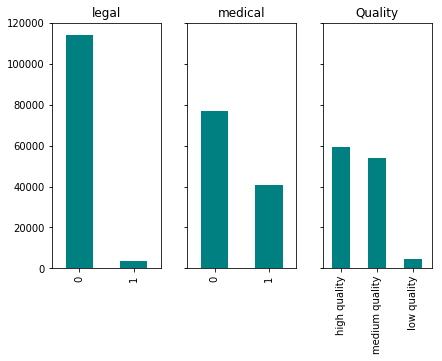

In [13]:
#define method to graph all variables in relation to price
def plot_category(feature, title, *args):
    count = marijuana[feature].value_counts()
    percent = 100*marijuana[feature].value_counts(normalize=True)
    df = pd.DataFrame({'count':count, 'percent':percent.round(1)})
    if args: 
        for arg in args:
            count.plot(kind='bar', title=title, ax=arg, color='teal')

#display features side by side
def describe_categories(f1, f2, f3):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
    #layout adjustments
    fig.tight_layout()
    plt.rc('xtick', labelsize=10)   
    plt.rc('ytick', labelsize=10)
    #plots
    plot_category(f1, f1, ax1)
    plot_category(f2, f2, ax2)
    plot_category(f3, 'Quality', ax3)

#plot graphs
describe_categories('legal', 'medical', 'strquality')
#might be interesting to separate by days before and after being legal

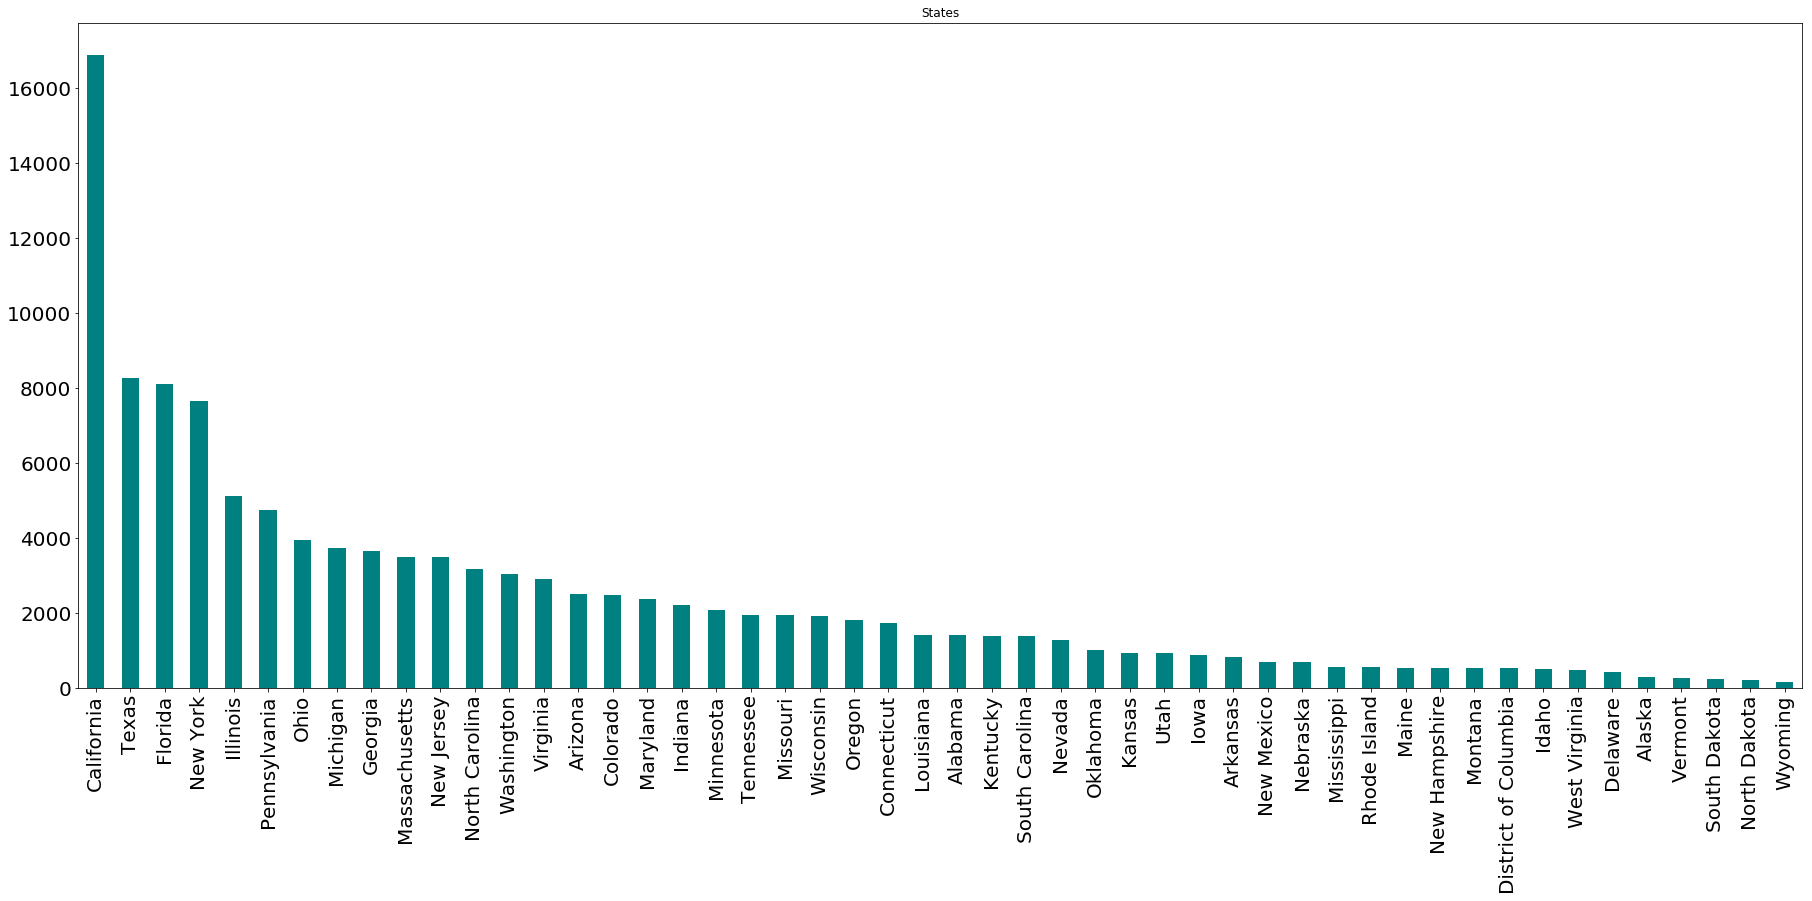

In [14]:
#for states, adjust plots before displaying
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
fig_st, ax = plt.subplots(ncols=1, figsize=(25, 10))
fig_st.tight_layout()
plot_category('State', 'States', ax)

### Sales weighted by population
May be useful to find **population data for states** in order to scale sales according to population. For example, CA has the highest population, as with Texas etc. In this case, we will scale by counting sales by state per 100,000 people.  
$Sales = \frac{Total sales per state}{State population} x 100,000$

In [15]:
#add sale population weights
marijuana['2012 Sales_Wt'] = (1/marijuana['pop_2012'])*100000
marijuana['2013 Sales_Wt'] = (1/marijuana['pop_2013'])*100000
marijuana.describe().round(5)

,price,quantityoz,quality_score,ppo,state_code,gramsperoz,quantity,lprice,lquantity,ppg,...,dayspost2012,dayspostlegal,legalpriceint,distance,electric,electric12,pop_2013,pop_2012,2012 Sales_Wt,2013 Sales_Wt
count,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,...,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,117931.00000,1.179310e+05,1.179310e+05,117931.00000,117931.00000
mean,142.39405,0.54759,2.46620,310.35727,26.47781,28.34952,15.52418,4.55129,2.38200,10.94416,...,373.86210,68.86210,0.05828,3320.25859,12.44907,12.73922,1.462389e+07,1.450481e+07,0.01599,0.01587
std,134.34898,0.39220,0.57061,205.37825,16.04735,0.00000,11.11831,0.94383,0.92791,7.23858,...,163.16288,163.16288,0.34847,1055.49553,2.66605,2.73521,1.175345e+07,1.163584e+07,0.02231,0.02208
min,4.00000,0.03500,1.00000,28.35539,1.00000,28.34952,1.00000,1.38629,0.00000,1.00021,...,0.00000,-305.00000,0.00000,856.98499,7.87000,8.37000,5.826580e+05,5.766260e+05,0.00263,0.00261
25%,50.00000,0.17600,2.00000,160.00000,12.00000,28.34952,4.98952,3.91202,1.60734,5.64383,...,245.00000,-60.00000,0.00000,2349.53390,10.91000,10.98000,5.928814e+06,5.884868e+06,0.00511,0.00509
50%,100.00000,0.50000,3.00000,300.00000,26.00000,28.34952,14.17476,4.60517,2.65146,10.58219,...,382.00000,77.00000,0.00000,3524.41700,11.42000,11.63000,9.895622e+06,9.882519e+06,0.01012,0.01011
75%,200.00000,1.00000,3.00000,400.00000,40.00000,28.34952,28.34952,5.29832,3.34461,14.10958,...,514.00000,209.00000,0.00000,4095.67600,14.78000,15.34000,1.965113e+07,1.957612e+07,0.01699,0.01687
max,1000.00000,1.00000,3.00000,2857.14286,56.00000,28.34952,28.34952,6.90776,3.34461,100.00000,...,640.00000,335.00000,4.60517,8851.25100,18.26000,18.89000,3.833252e+07,3.799988e+07,0.17342,0.17163


In [16]:
#Plot the state distribution of sales
#Drop Hawaii from population because we dont have sales data for that state
population = population[population.State != 'Hawaii']
#create a dataframe for calculating the weights by state and year
count = pd.DataFrame(marijuana['State'].value_counts())
count['sales2012'] = (count.values/(pd.DataFrame(population['2012 Population'])).values)*100000
count['sales2013'] = (pd.DataFrame(count['State'].values).values/(pd.DataFrame(population['2013 Population'])).values)*100000
#count['quant2012'] = (pd.DataFrame(marijuana.groupby(['year','State'])['quantity'].sum()))
count.head()

,State,sales2012,sales2013
California,16892,2929.455141,2899.127790
Texas,8261,144.308185,143.851869
Florida,8119,437.285908,437.846222
New York,7651,110.959350,109.748306
Illinois,5116,62.492152,61.934009


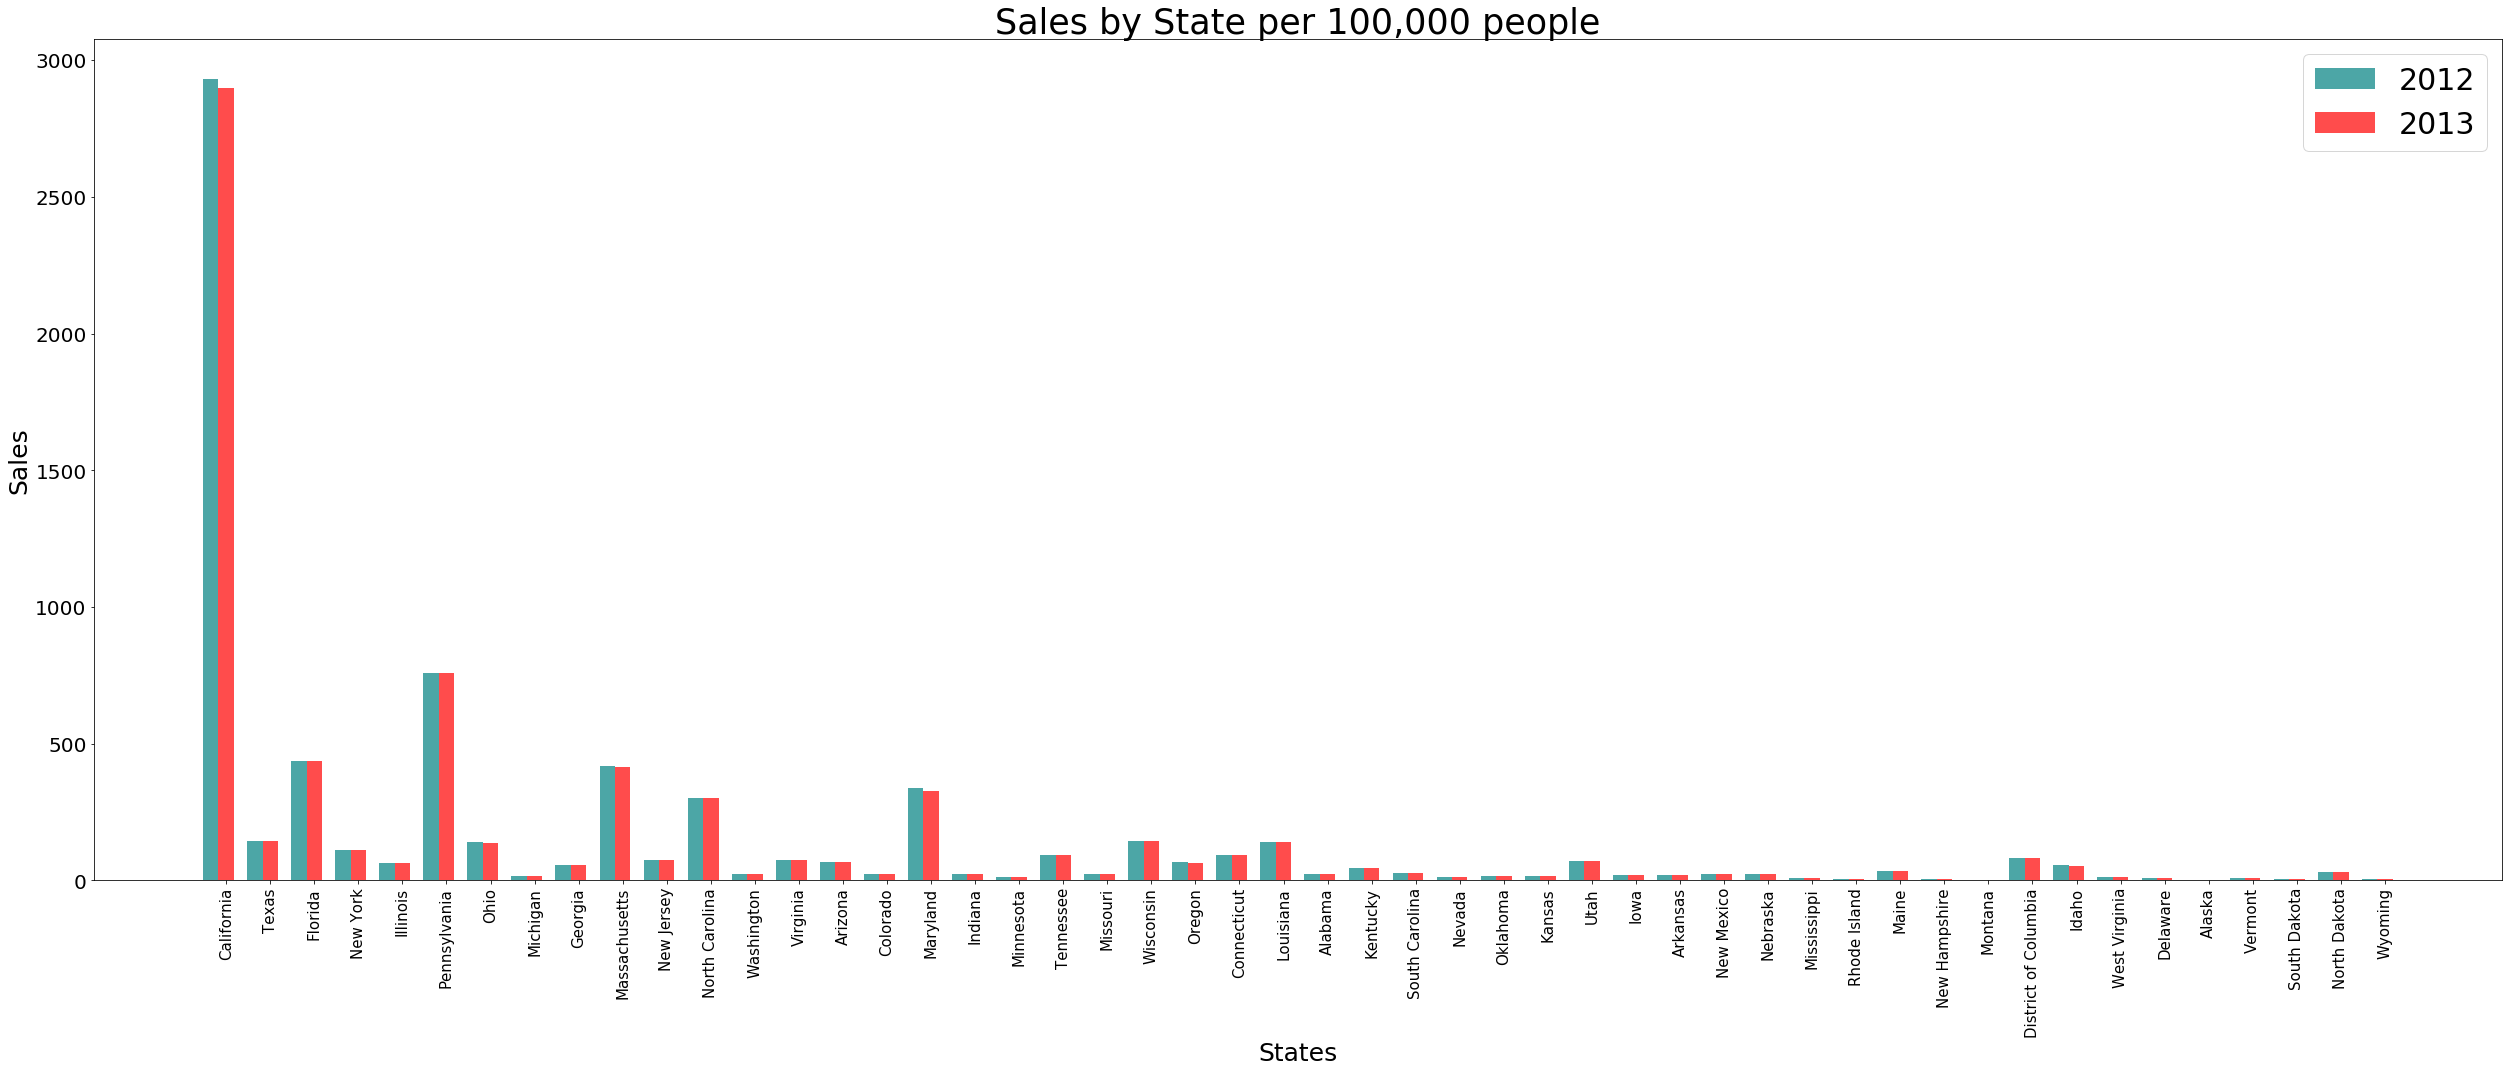

In [17]:
# create plot method
def states_plot(bar1data, bar2data, title):
    fig, ax = plt.subplots(figsize=(35,15))
    index = np.arange(len(bar1data.index)) #50 states
    bar_width = 0.35
    opacity = 0.7
    #define bar plots and create
    rects1 = plt.bar(index, bar1data, bar_width, alpha=opacity, color='teal', label='2012')
    rects2 = plt.bar(index + bar_width, bar2data, bar_width, alpha=opacity, color='r', label='2013')
    #formatting plot items
    plt.xlabel('States', fontsize=25)
    plt.ylabel(title, fontsize=25)
    plt.title(title + ' by State per 100,000 people', fontsize=35)
    plt.xticks(index + bar_width, list(bar1data.index.values))
    ax.set_xticklabels(labels=list(bar1data.index.values), rotation=90, fontsize=15)
    plt.legend(fontsize=30)
    plt.tight_layout()
    #Display plot
    plt.show()

states_plot(count['sales2012'], count['sales2013'], 'Sales')

It seems even when we scale values by state, California is still very different from the rest of the states. There are a few other states like Texas, Illnois, Georgia, Colorado, that have higher than most usage. Because we'd like to see how most states act, now we separate the states into two groups. High usage and low usage. Any states who have at least 100 sales per 100,000 people will be considered high usage, and the rest will be placed in the low usage group as follows:

**Note:** No sales data for Hawaii so it is excluded

In [18]:
#Separate at 100 per 100,000 sales by state
count['Usage'] = 'High'
count['Usage'][count.sales2012 < 100] = 'Low'
#display new column
count.head()

C:\Users\srija\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,sales2012,sales2013,Usage
California,16892,2929.455141,2899.127790,High
Texas,8261,144.308185,143.851869,High
Florida,8119,437.285908,437.846222,High
New York,7651,110.959350,109.748306,High
Illinois,5116,62.492152,61.934009,Low


#### High Usage States:
For its size, TX seems to have very low usage (relatively). Conversely, PA (based on its population) seems to have very high usage. Would be interesting to compare neighboring states like NJ, NY, DC. DC proximity to Philadelphia might explain some of this usage. But Delaware is also close and they are in the low usage group (granted they have low population)

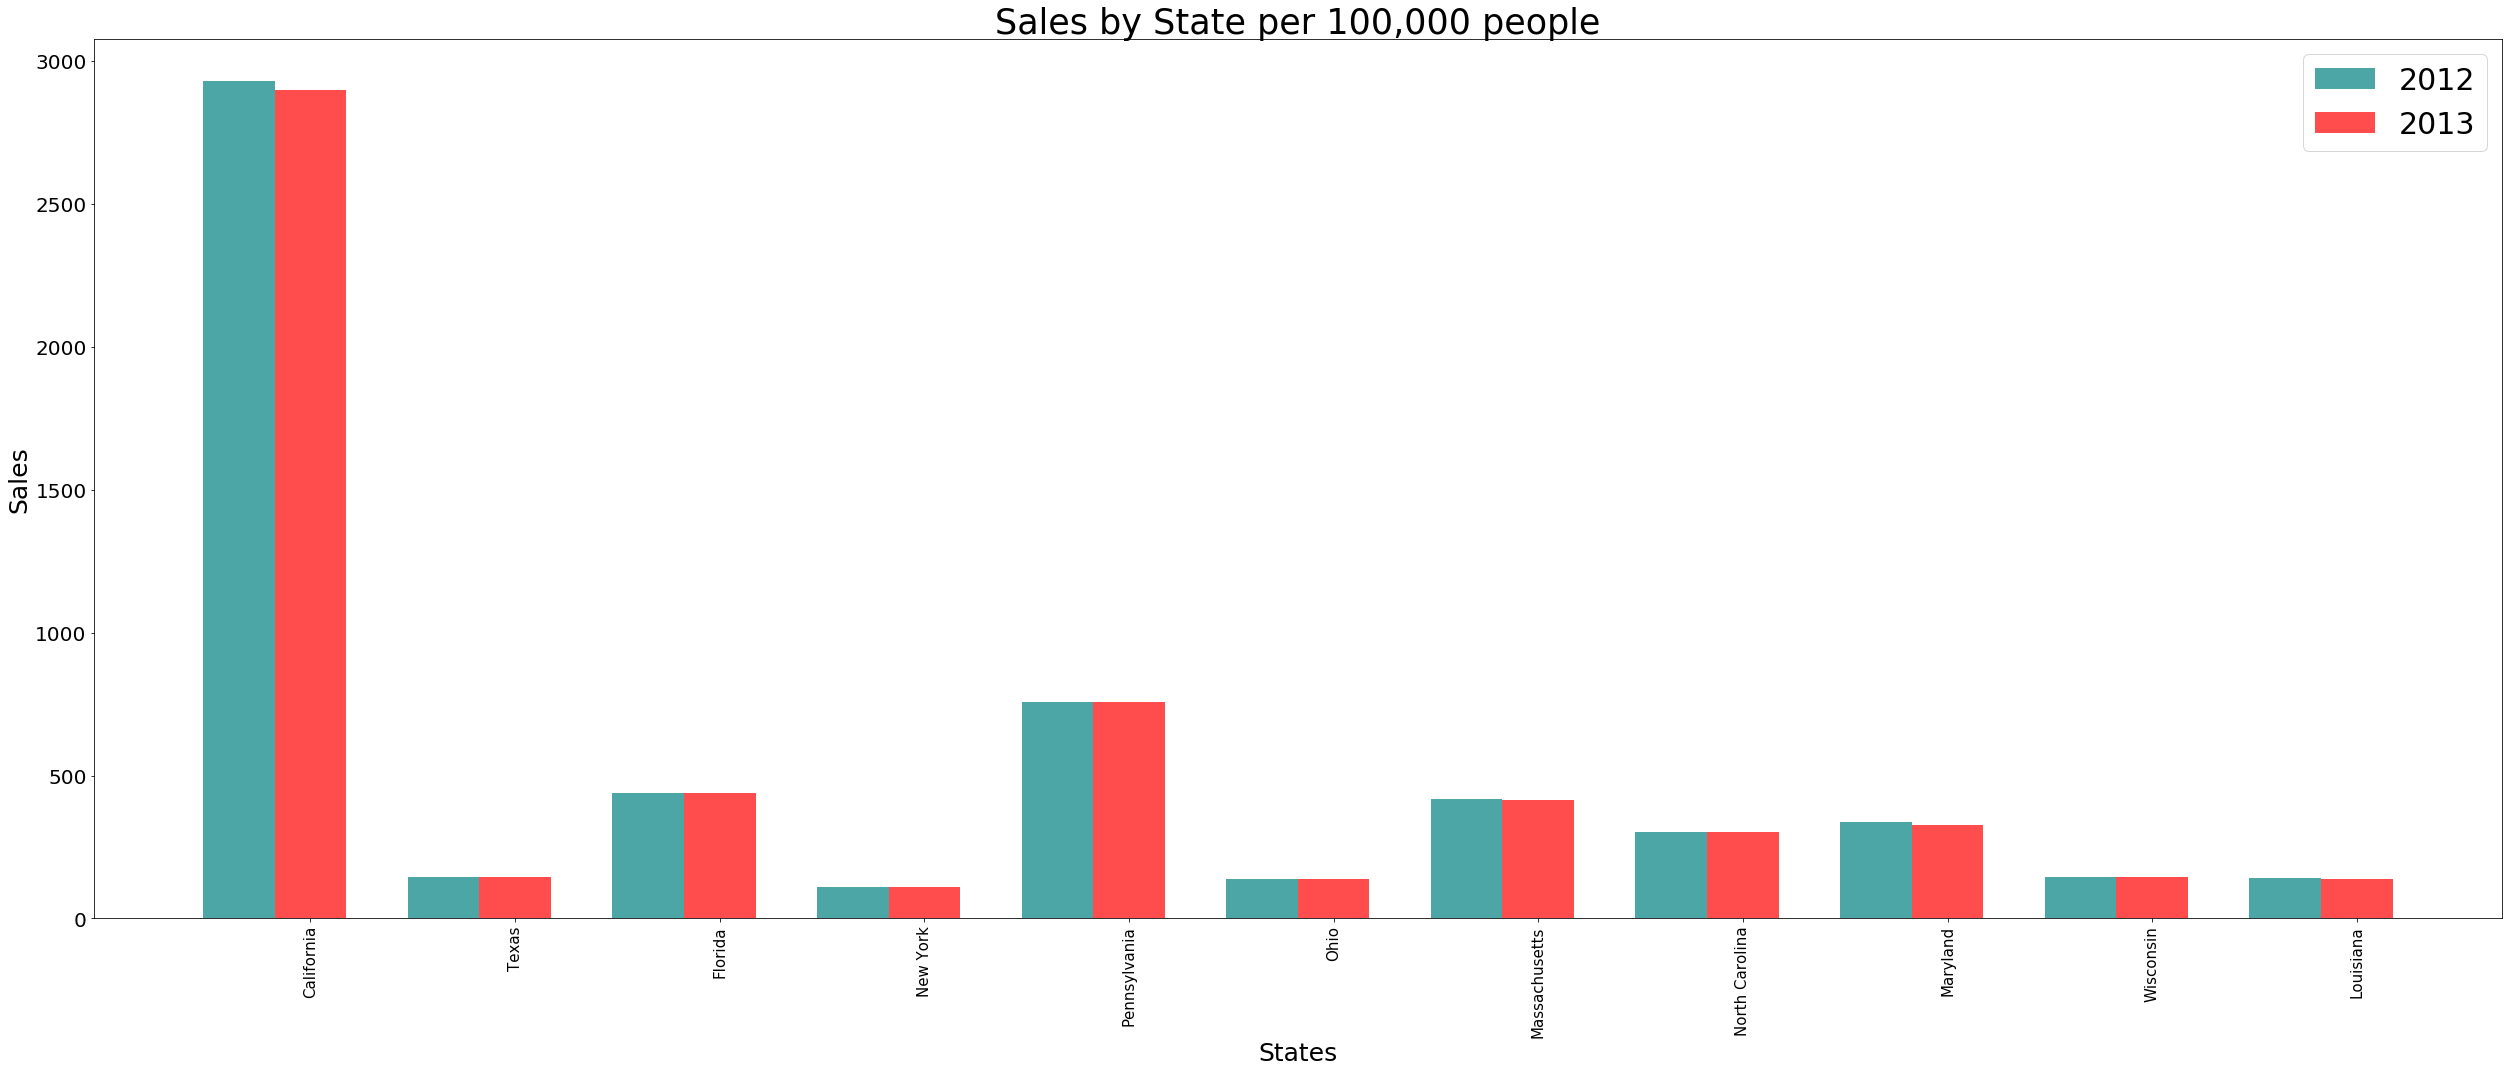

In [19]:
#get dataframes for each plot
count_high = count[count.Usage == 'High']
count_low = count[count.Usage == 'Low']

#High usage/sales plot
states_plot(count_high['sales2012'], count_high['sales2013'], 'Sales')

#### Low Usage States:
Some interesting states to focus on based on how similar they are in usage:
- Given their populations, TN, ND, VA, UT, ME, DC, and CT have relatively high sales
- Comparing Washington, Colorado (legal) and other states with around the same sales rate is interesting

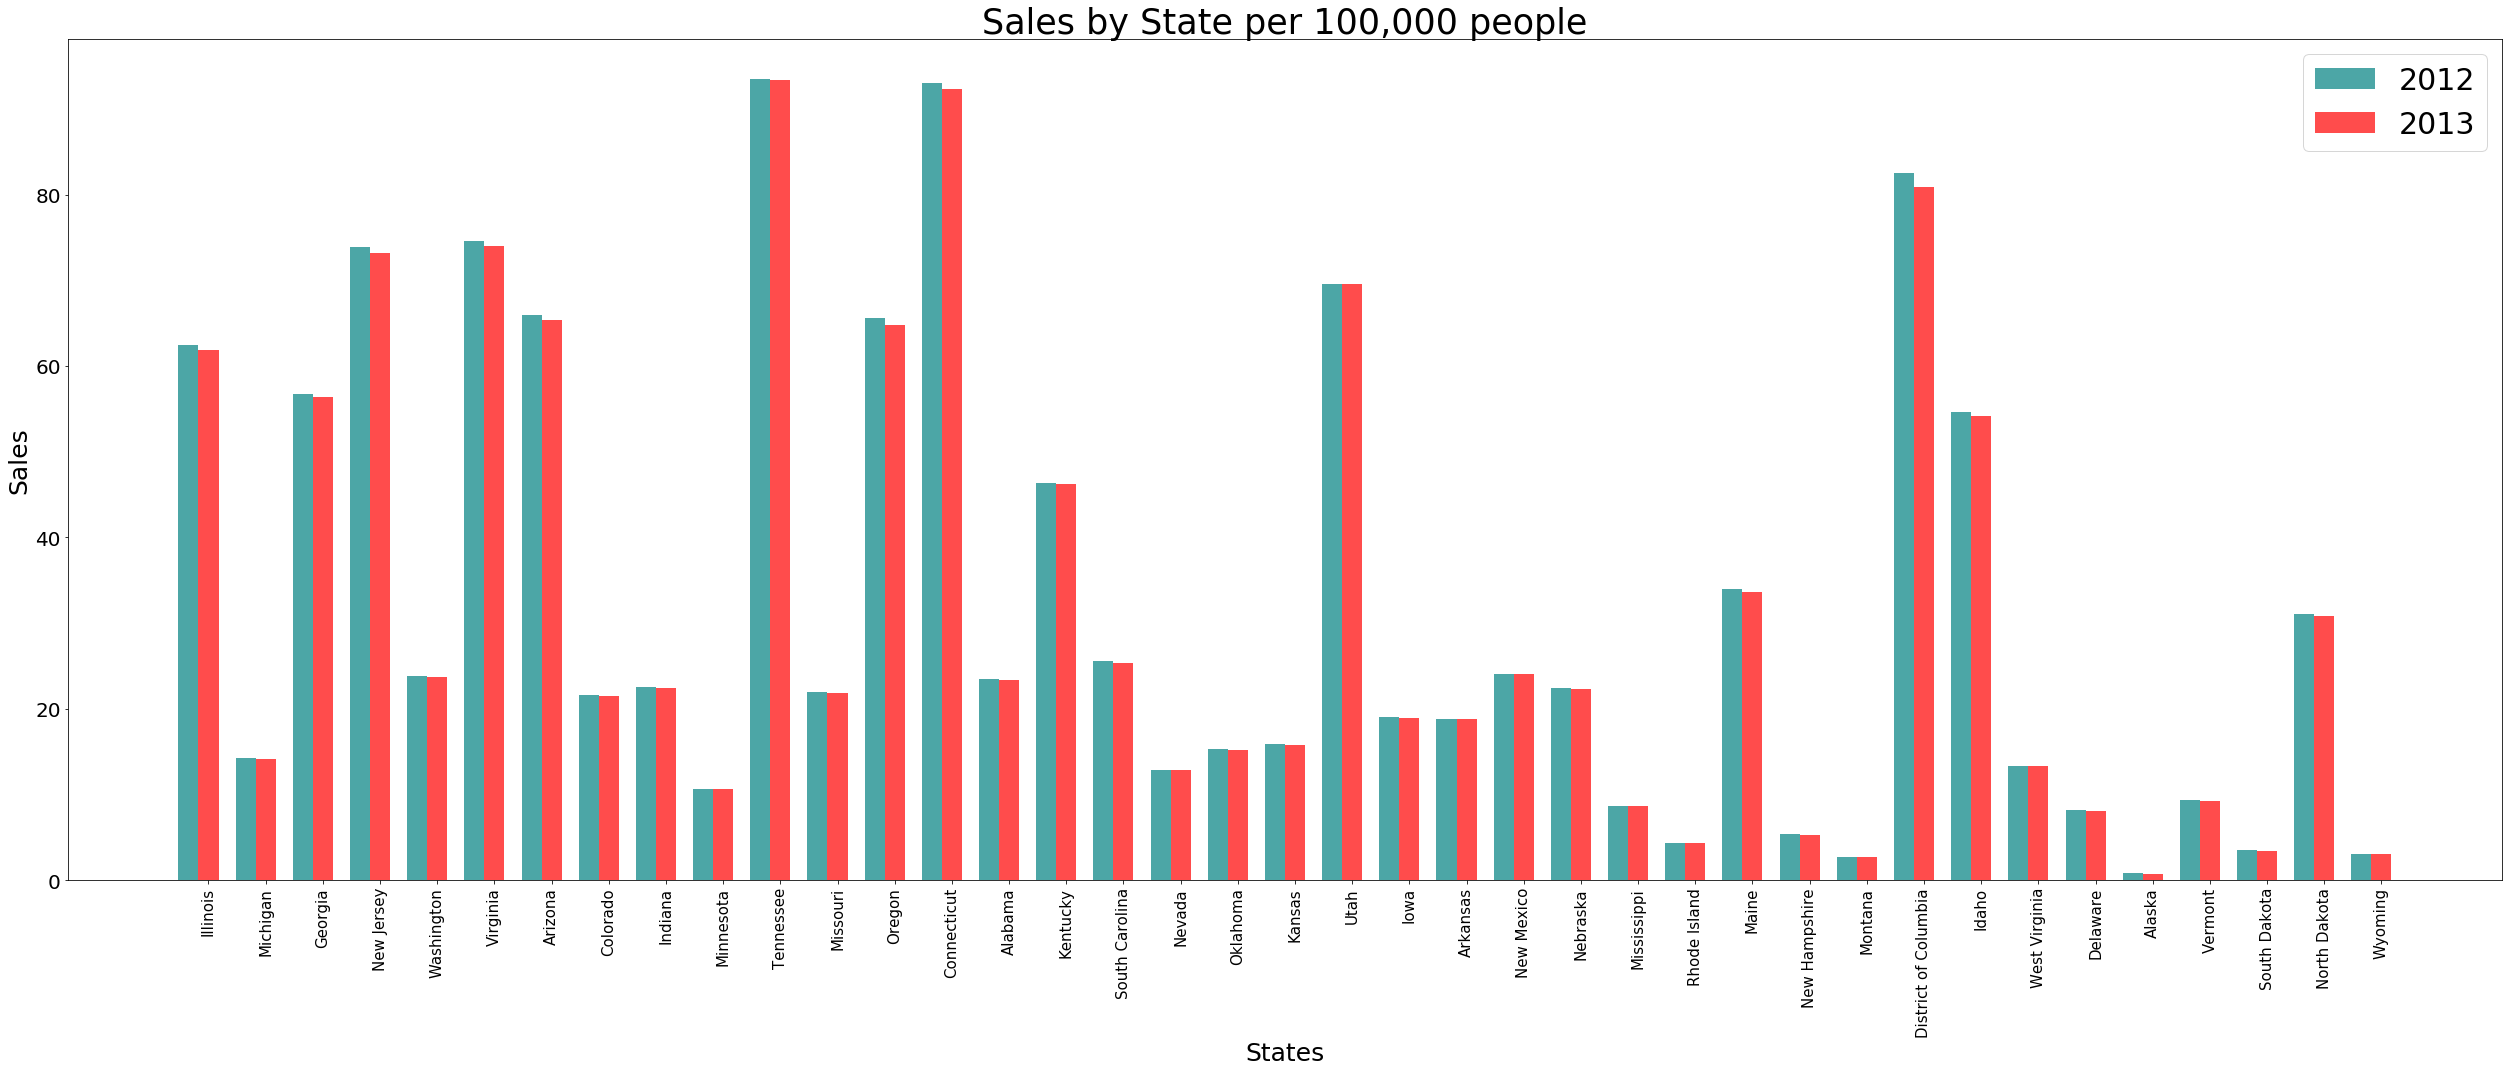

In [20]:
#Low usage sales plot
states_plot(count_low['sales2012'], count_low['sales2013'], 'Sales')

### Purchase Quantity weighted by Population
Now we look at the total quantity purchased by state in grams weighted by the population for that state. For example, CA has the highest population, as with Texas etc. In this case, we will scale by counting sales by state per 100,000 people.  
$Quantity = \frac{Total quantity (grams) per state}{State population} x 100,000$

In [21]:
#add quantities to table
data2012 = marijuana[marijuana['year']==2012]
data2013 = marijuana[marijuana['year']==2013]
data2012 = pd.DataFrame(data2012.groupby('State')['quantity'].sum())
data2013 = pd.DataFrame(data2013.groupby('State')['quantity'].sum())
count['quant2012'] = data2012
count['quant2013'] = data2013
count.head()

,State,sales2012,sales2013,Usage,quant2012,quant2013
California,16892,2929.455141,2899.127790,High,137685.577890,156149.030596
Texas,8261,144.308185,143.851869,High,58605.252725,68994.583545
Florida,8119,437.285908,437.846222,High,55570.161998,67146.665252
New York,7651,110.959350,109.748306,High,55664.640066,63087.182725
Illinois,5116,62.492152,61.934009,Low,34131.460960,39147.165129


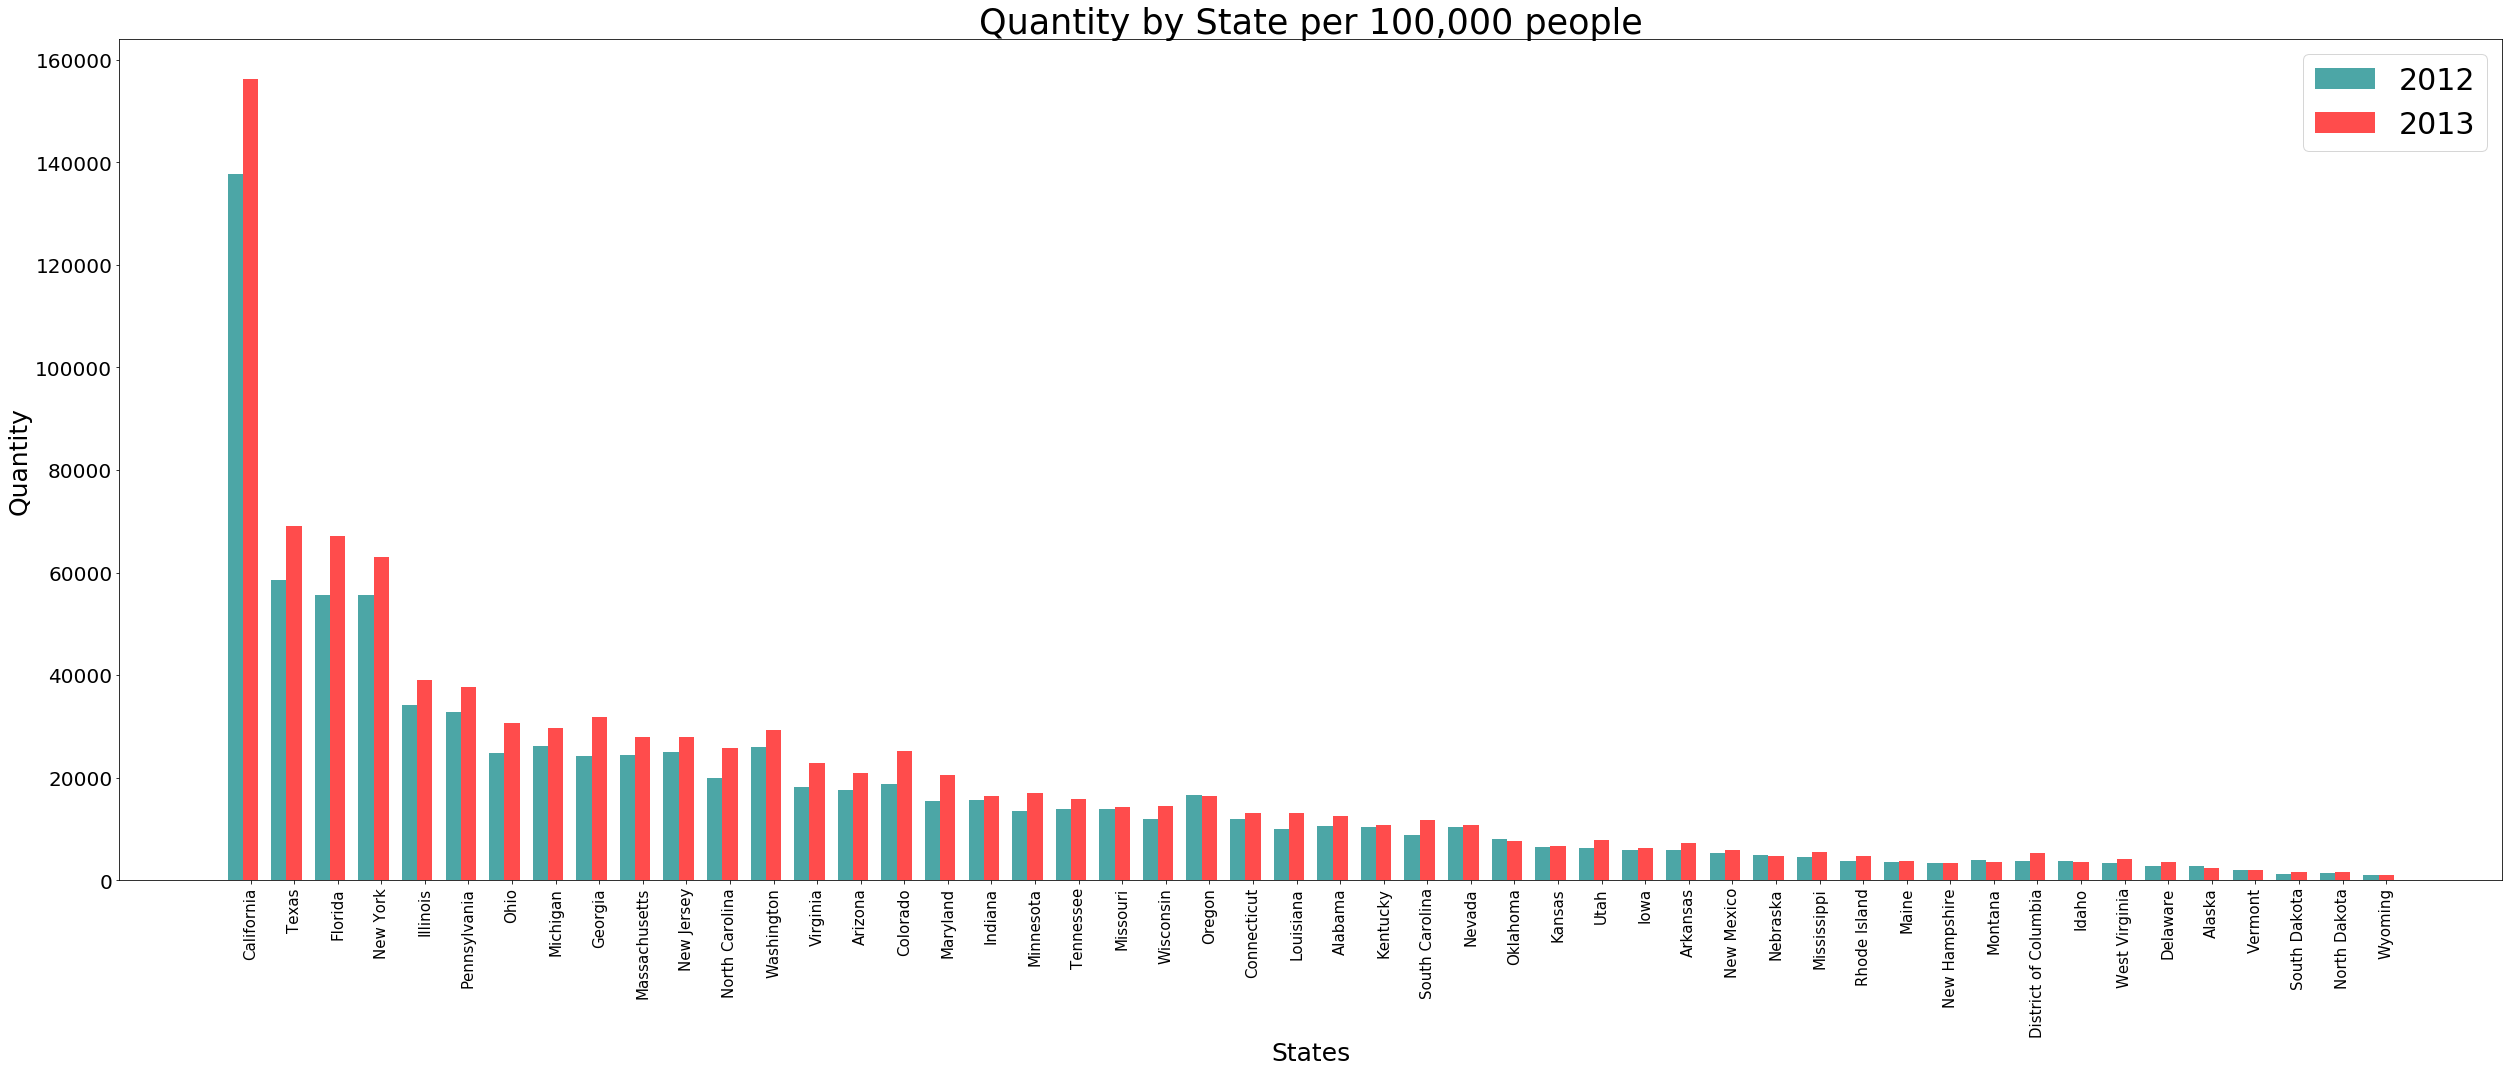

In [22]:
states_plot(count['quant2012'], count['quant2013'], 'Quantity')

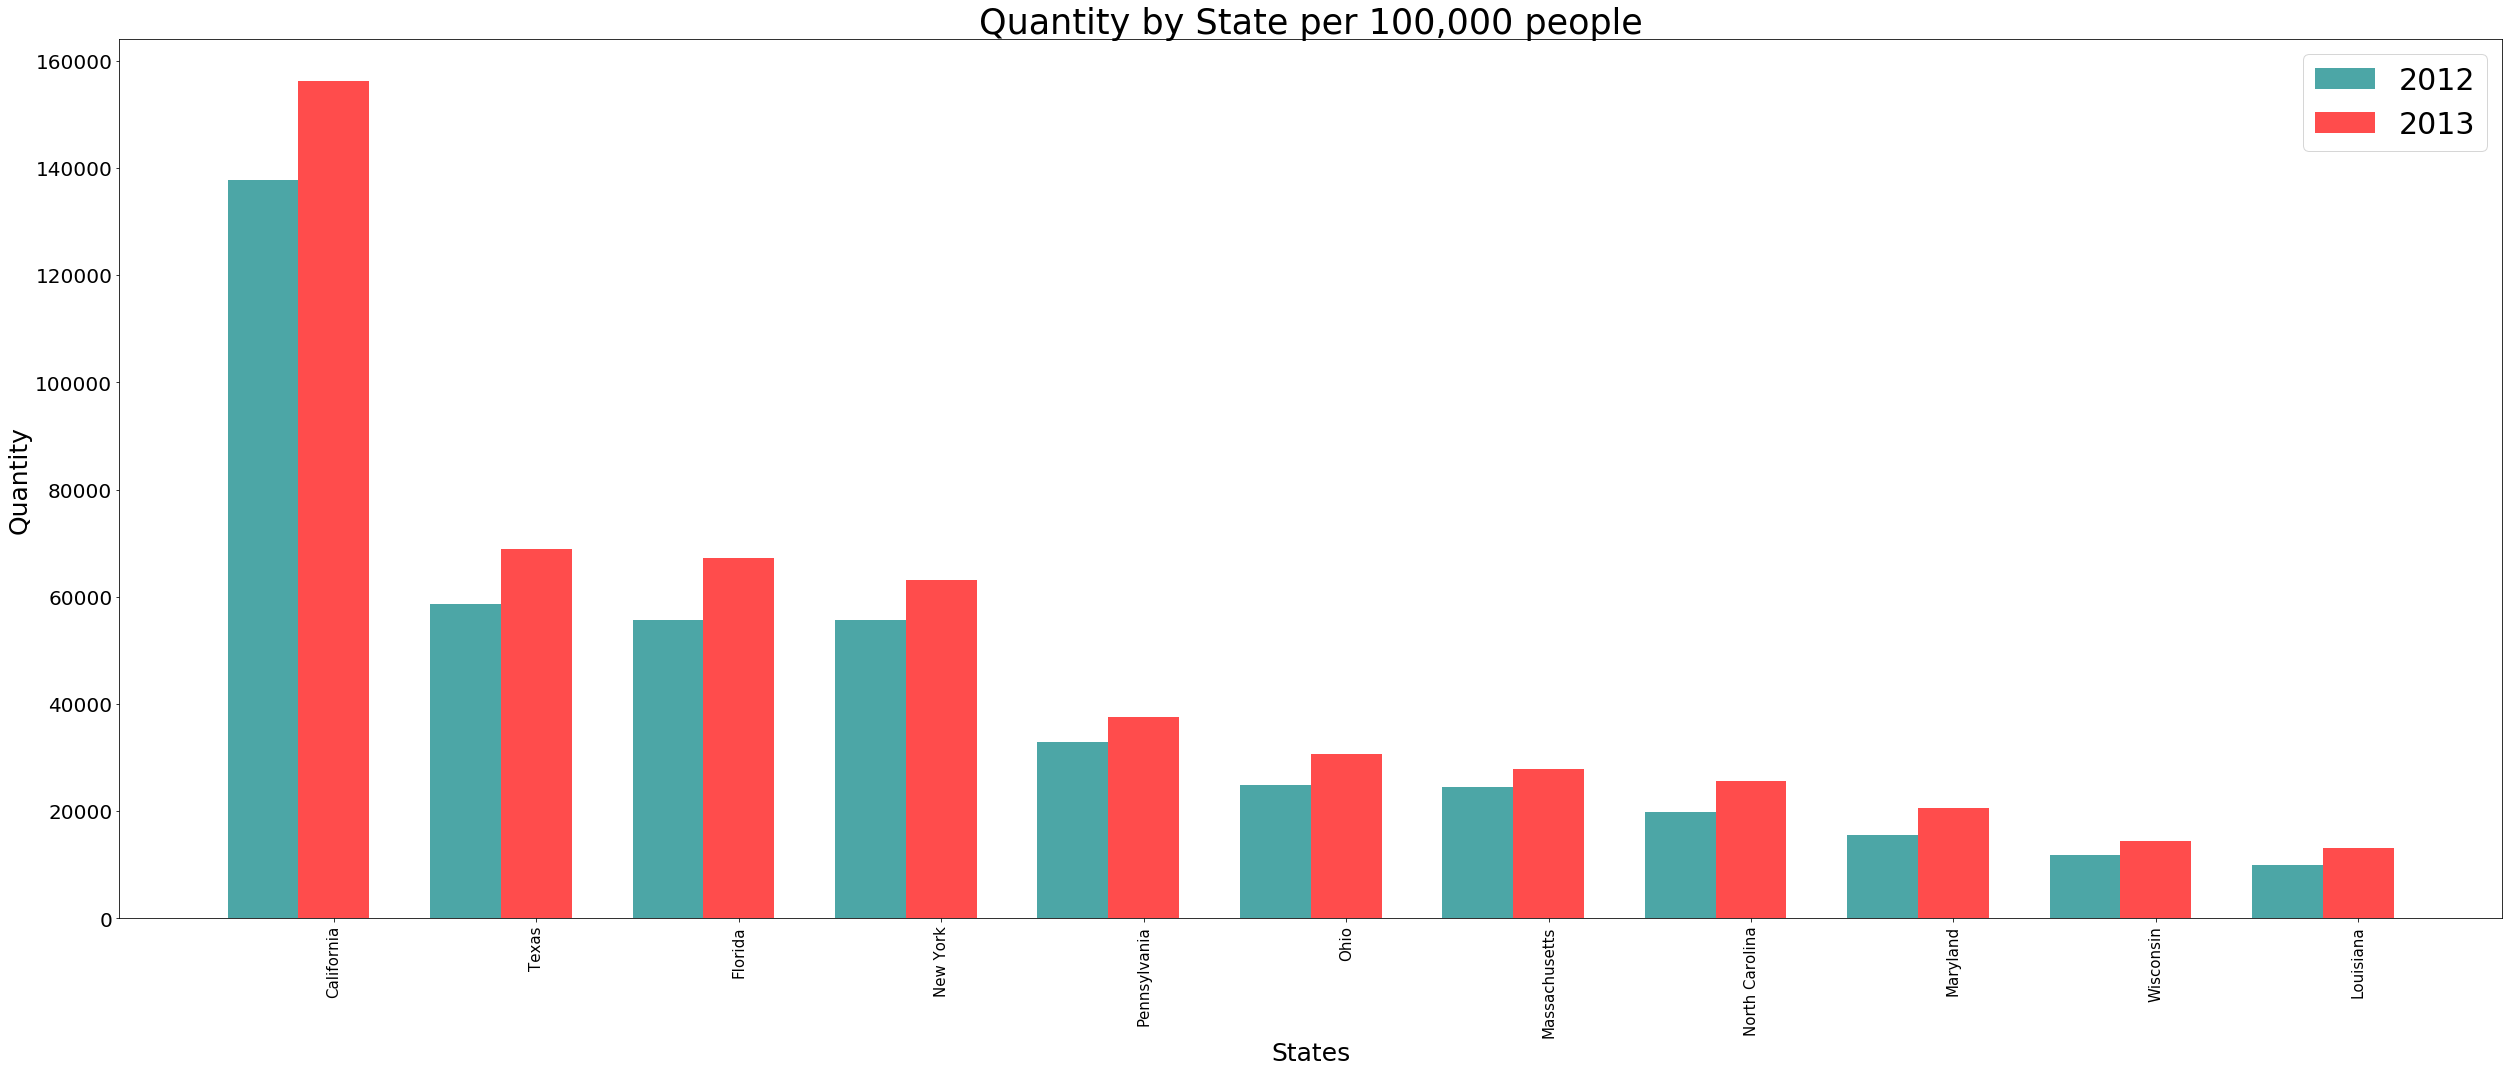

In [23]:
#quantities by groups
quant_high = count[count['Usage'] =='High']
quant_low = count[count['Usage'] =='Low']

#High usage
states_plot(quant_high['quant2012'], quant_high['quant2013'], 'Quantity')

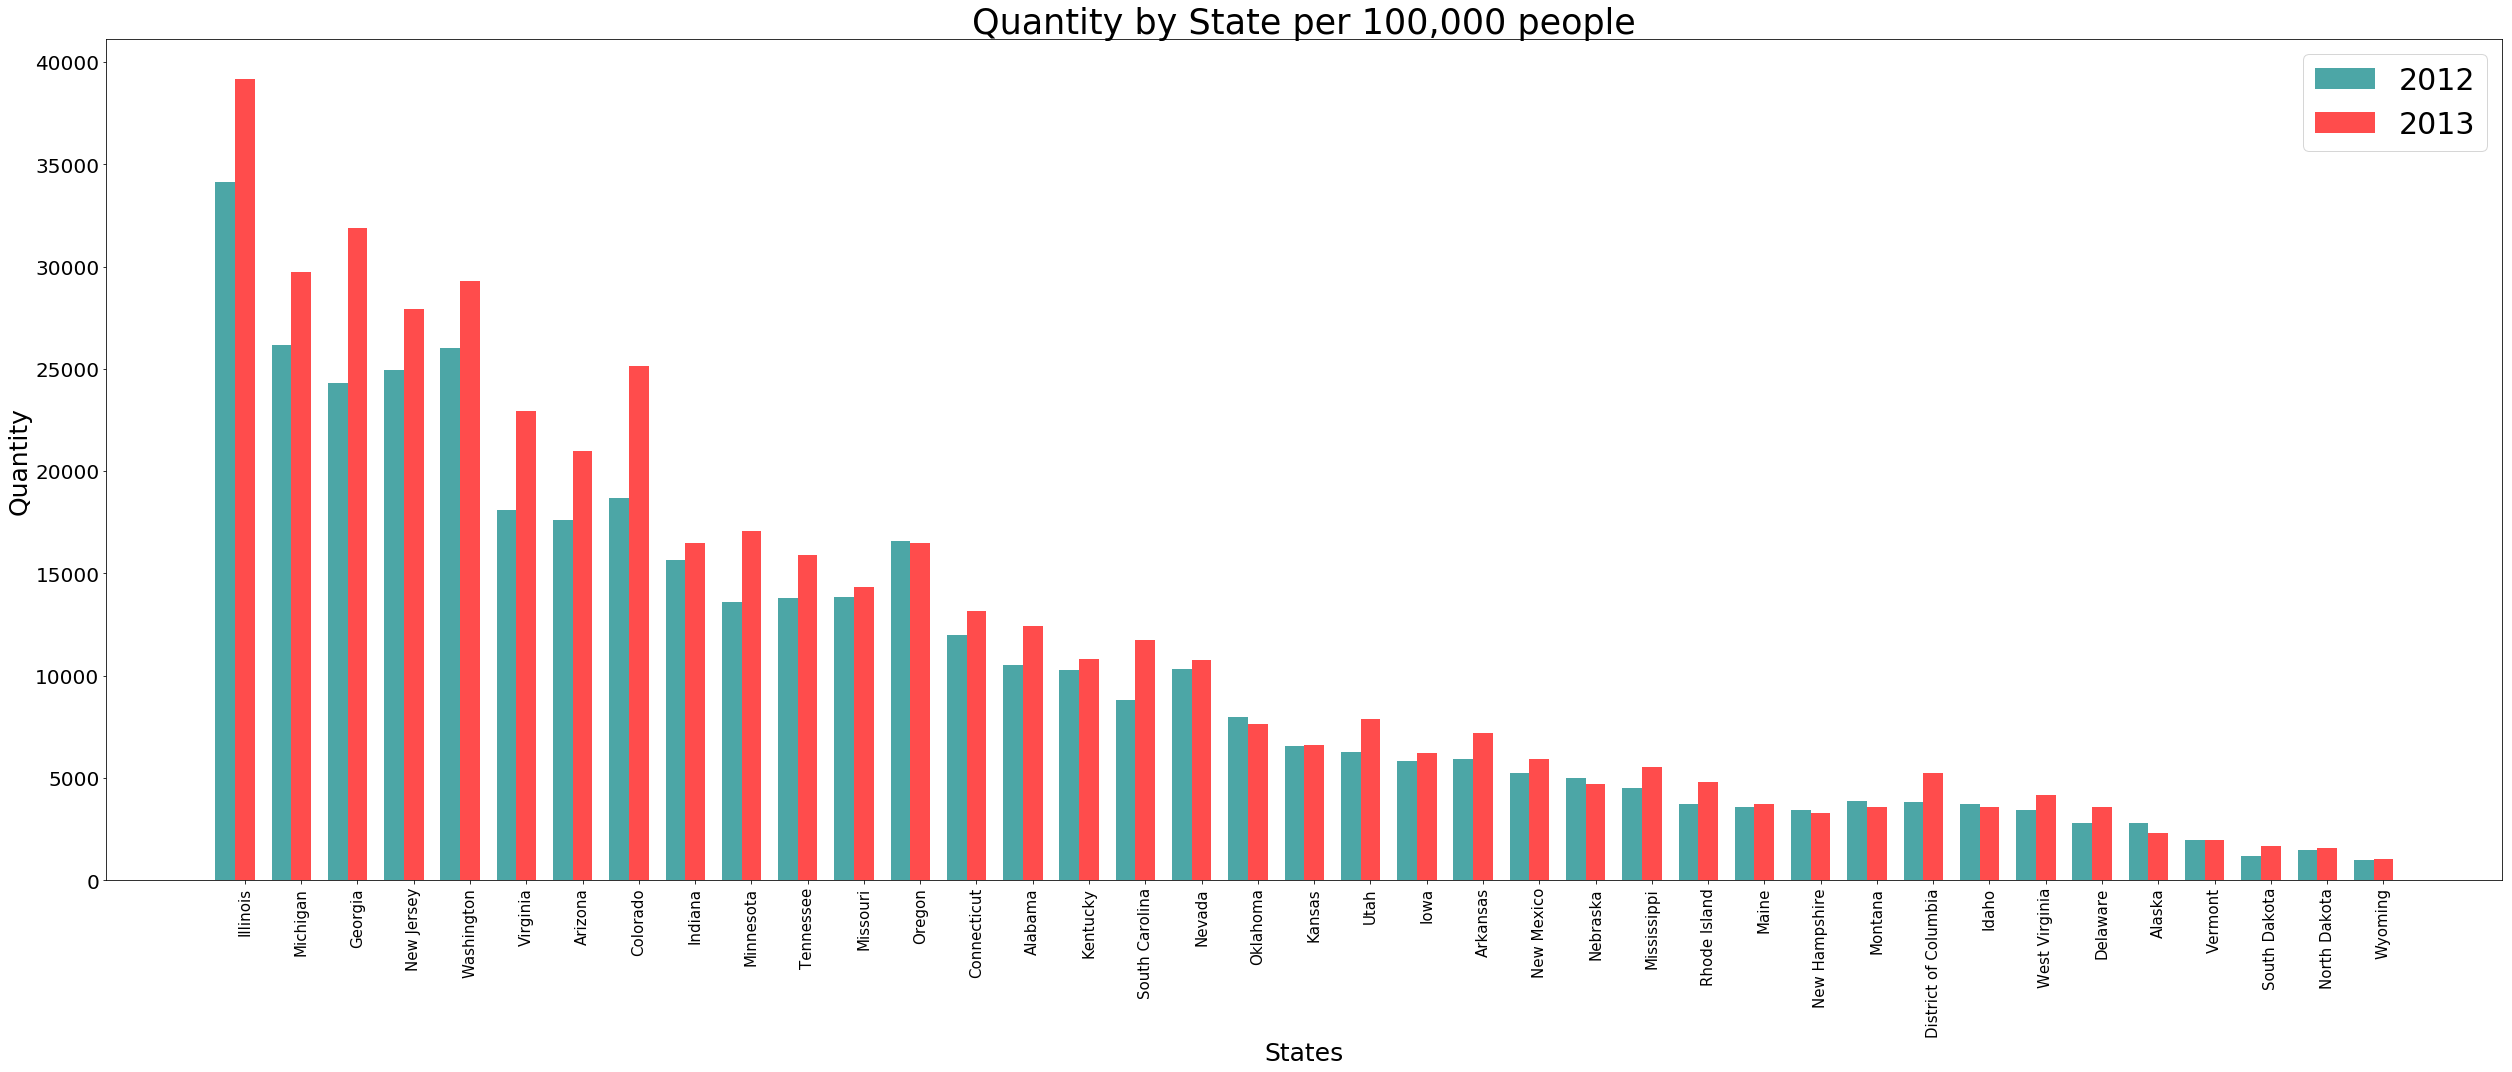

In [24]:
#Low usage
states_plot(quant_low['quant2012'], quant_low['quant2013'], 'Quantity')

### Quantity Weights Integrated to Dataset
Since this is looking significant in separating the states, will add the quantity weights to the bigger dataset. Additionally, now we only include our variables of interest in the numerical features to narrow our scope of review to only help pin down variables that affect price and quantity. 

In [25]:
#add quantity population weights
marijuana['2012 Quant_Wt'] = (marijuana['quantity']/marijuana['pop_2012'])*100000
marijuana['2013 Quant_Wt'] = (marijuana['quantity']/marijuana['pop_2013'])*100000
marijuana.head(5)

,State,location,price,strquant,strquality,date_old,quantityoz,quality_score,ppo,date,...,legalpriceint,distance,electric,electric12,pop_2013,pop_2012,2012 Sales_Wt,2013 Sales_Wt,2012 Quant_Wt,2013 Quant_Wt
0,Alabama,"Gadsden, Alabama",280,an ounce,high quality,16-Mar-13,1.0,3,280.0,3/16/2013 0:00,...,0.0,3150.0330,11.4,11.35,4833722,4817528,0.020758,0.020688,0.588466,0.586495
1,Alabama,"Auburn University, Alabama",370,an ounce,medium quality,5-Mar-13,1.0,2,370.0,3/5/2013 0:00,...,0.0,3078.4470,11.4,11.35,4833722,4817528,0.020758,0.020688,0.588466,0.586495
2,Alabama,"Auburn University, Alabama",300,an ounce,high quality,12-Sep-13,1.0,3,300.0,9/12/2013 0:00,...,0.0,3078.4470,11.4,11.35,4833722,4817528,0.020758,0.020688,0.588466,0.586495
3,Alabama,"Birmingham, Alabama",80,a half ounce,high quality,9-Jun-13,0.5,3,160.0,6/9/2013 0:00,...,0.0,3045.9939,11.4,11.35,4833722,4817528,0.020758,0.020688,0.294233,0.293247
4,Alabama,"Alberta, Alabama",115,an ounce,low quality,3-Jul-13,1.0,1,115.0,7/3/2013 0:00,...,0.0,2954.1150,11.4,11.35,4833722,4817528,0.020758,0.020688,0.588466,0.586495


Interesting that for Washington and Colorado where sales are legal, the quantity purchased falls in the low usage group.

#### c) Numerical Features
Distribution of all numerical features

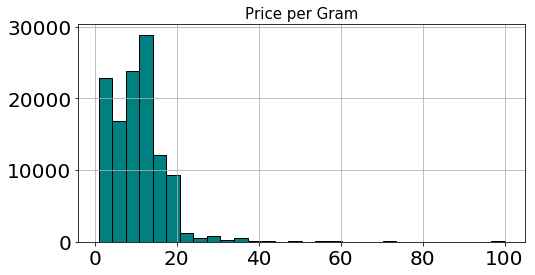

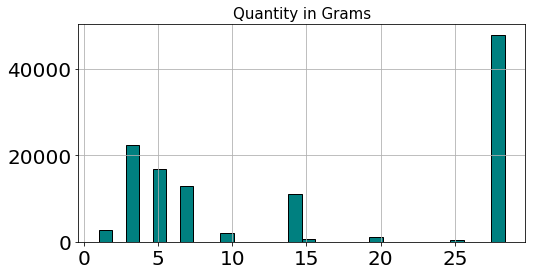

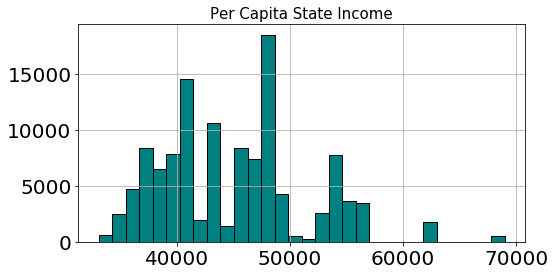

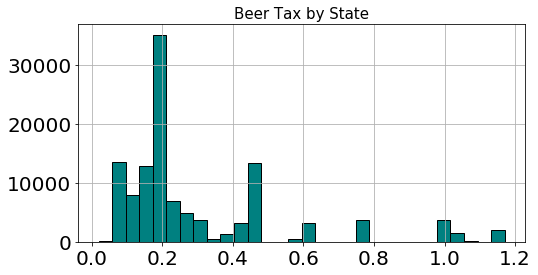

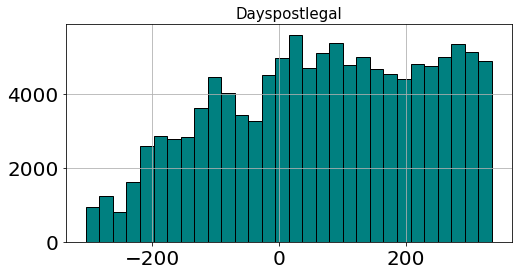

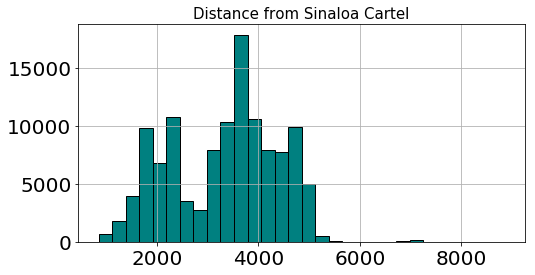

In [26]:
#define method to view numerical features
def desc_num_feature(df, feature, title, bins=30, edgecolor='k', **kwargs):
    fig, (ax) = plt.subplots(figsize=(8,4))
    df[feature].hist(bins=bins, edgecolor=edgecolor, ax=ax, color='teal', **kwargs)
    #sns.distplot(np.log(marijuana[feature]), ax=ax2,color='red')
    ax.set_title(title, size=15)
    
#Some numerical variables of interest
num_interest = ['ppg', 'quantity', 'income', 'beer', 'dayspostlegal', 'distance']
num_titles = ['Price per Gram', 'Quantity in Grams', 'Per Capita State Income', 'Beer Tax by State'\
             , 'Dayspostlegal', 'Distance from Sinaloa Cartel']

#plot numerical features
for i in num_interest:
    desc_num_feature(marijuana, i, num_titles[num_interest.index(i)])

#### Some observations:
- Distance from cartel seems to be a good indicator of the distribution of sales
- Most purchases were made after marijuana became legal. May be helpful to review by state
- Beer state tax and per capita state income would be interesting to review by state or even region in combination with distance from cartel since the cartel is in Mexico, closer to the southern side of the U.S.
- Quantity and price divide into clear segments/clusters


## Price and Quantity in All States
From before, both Washington and Colorado fall in the "low usage" groups for sales and quantity purchased (in grams) and they are the only states where marijuana is legal. With this, we can look just all the states and compare to the two states to see if they share any features of interest that would affect the price and quantity of marijuana purchased. 


**Below, some variables are excluded from the correlation table** because we anticipate that they would be highly correlated with others. E.g. 2012 Population would be highly correlated with 2013 Population, same with the different price and quantity measures as well as electricity cost. Additionally, all the weights of interest have been added to the features list and again, because we have two years, we will use the 2013 weights because 2012 and 2013 are highly correlated.

In [27]:
#update list of numerical features to add weights and only include interest features
num_interest.extend(['2013 Sales_Wt','2013 Quant_Wt'])

In [28]:
#Correlation plot for the legal states features
#excluding some items that don't affect the two states
df_num_features = [e for e in num_interest if e not in {'dayspost2011', 'dayspost2012', 'gramsperoz', 'price', 'quantityoz', 'electric12'}]
#add quality indicators
marijuana['quality_score_high'] = 0
marijuana['quality_score_medium'] = 0
marijuana.loc[marijuana.quality_score == 3, 'quality_score_high'] = 1
marijuana.loc[marijuana.quality_score == 2, 'quality_score_medium'] = 1
#add to list of numerical features
df_num_features.extend(['quality_score_high','quality_score_medium'])
marijuana[df_num_features].corr()

,ppg,quantity,income,beer,dayspostlegal,distance,2013 Sales_Wt,2013 Quant_Wt,quality_score_high,quality_score_medium
ppg,1.000000,-0.341761,0.035579,0.013852,-0.008217,0.102148,0.027994,-0.111745,0.159564,-0.126908
quantity,-0.341761,1.000000,0.013832,-0.002668,0.011010,-0.052496,-0.017279,0.378120,0.055973,-0.056816
income,0.035579,0.013832,1.000000,-0.323608,0.014469,0.366855,0.020732,0.022158,-0.034067,0.046856
beer,0.013852,-0.002668,-0.323608,1.000000,0.065335,0.052109,0.047988,0.044043,0.034436,-0.034761
dayspostlegal,-0.008217,0.011010,0.014469,0.065335,1.000000,-0.002670,-0.000685,0.002630,-0.029450,0.034577
distance,0.102148,-0.052496,0.366855,0.052109,-0.002670,1.000000,0.195357,0.136173,0.010424,-0.005279
2013 Sales_Wt,0.027994,-0.017279,0.020732,0.047988,-0.000685,0.195357,1.000000,0.739339,-0.002698,0.001274
2013 Quant_Wt,-0.111745,0.378120,0.022158,0.044043,0.002630,0.136173,0.739339,1.000000,0.022925,-0.024400
quality_score_high,0.159564,0.055973,-0.034067,0.034436,-0.029450,0.010424,-0.002698,0.022925,1.000000,-0.925935
quality_score_medium,-0.126908,-0.056816,0.046856,-0.034761,0.034577,-0.005279,0.001274,-0.024400,-0.925935,1.000000


### Co-linearity:
With all the states included, there is one glaring relationship that we can be mindful about - the quality scores are highly correlated even though the low score dummy variable has been dropped. 
- The target variables are most correlated with each other. 
- Distance is the next most correlated with both quantity and income and may have explaining power for how price and quantity change. Beer tax and distance are also correlated with income.
- Price per gram is also significantly correlated with the quality of the product

### Legal States
Reviewing correlation table for all numerical features of interest for just the legal states: Colorado and Washington.

In [29]:
#double checking legal states for our entire dataset
df_legal = marijuana[marijuana['legal']==1]
df_legal.State.unique()

array(['Colorado', 'Washington'], dtype=object)

In [30]:
df_legal[df_num_features].corr()

,ppg,quantity,income,beer,dayspostlegal,distance,2013 Sales_Wt,2013 Quant_Wt,quality_score_high,quality_score_medium
ppg,1.000000,-0.266735,0.007970,-0.042571,-0.015723,-0.057393,0.052638,-0.246997,0.065305,-0.071102
quantity,-0.266735,1.000000,-0.018287,0.002694,-0.014883,0.001049,0.000472,0.965246,0.102606,-0.094606
income,0.007970,-0.018287,1.000000,-0.494229,0.388314,-0.522705,0.537463,0.100377,0.022954,-0.020745
beer,-0.042571,0.002694,-0.494229,1.000000,0.208473,0.917729,-0.940631,-0.208836,-0.038559,0.040711
dayspostlegal,-0.015723,-0.014883,0.388314,0.208473,1.000000,0.092336,-0.091885,-0.035168,-0.038509,0.043726
distance,-0.057393,0.001049,-0.522705,0.917729,0.092336,1.000000,-0.974583,-0.217825,-0.045024,0.047523
2013 Sales_Wt,0.052638,0.000472,0.537463,-0.940631,-0.091885,-0.974583,1.000000,0.224785,0.050678,-0.052916
2013 Quant_Wt,-0.246997,0.965246,0.100377,-0.208836,-0.035168,-0.217825,0.224785,1.000000,0.107608,-0.100234
quality_score_high,0.065305,0.102606,0.022954,-0.038559,-0.038509,-0.045024,0.050678,0.107608,1.000000,-0.959779
quality_score_medium,-0.071102,-0.094606,-0.020745,0.040711,0.043726,0.047523,-0.052916,-0.100234,-0.959779,1.000000


### <u>Co-linearity<u>
There are a few variables above that are highly correlated with each other in the legal states. 
- Distance from the cartel and weighted sales are all highly correlated with each other, and with the beer tax in the states ($>91$%) 
- While keeping all of them, there are no high correlations observed with **our variables of interest - price and quantity**
- Price and quantity have a relatively significant relationship with each other compared to the relationships they each have with all other variables
- As opposed to comparing all states, in the legal states price and quality have less correlation, while quantity and quality have a more significant observable relationship.
- The high and medium quality product are still highly correlated.

**Removal of some higher correlated items** might allow us to see if the price and quantity are affected. Just observing the correlation table above, all variables that occur in both years are highly correlated with each other variables which is why we only include 2013 and remove 2012population, and the sales and quantity weights for 2012 first. The main difference between these two years is that Washington turned to a fully legalized state (See below). 

### Medical but not Legal States
Here we review whether access changes customer's sensitivity to the price and quantity they want to consume.

In [31]:
#subset of only the medical states where recreational use is not legal
def medical_profile(year):
    df_medical = marijuana[(marijuana['medical']==1) & (marijuana['legal']==0) & (marijuana['year']==year)]
    print(year, 'States with medical use, no legal recreational use: ', len(df_medical.State.unique()),\
          '. These were: ',)
    for x in df_medical.State.unique(): print(x, ' ')
    return df_medical
#see 2012 profile
df_medical2012 = medical_profile(2012)
print('\n')
df_medical2013 = medical_profile(2013)

2012 States with medical use, no legal recreational use:  17 . These were: 
Alaska  
Arkansas  
California  
Colorado  
Connecticut  
Delaware  
District of Columbia  
Maine  
Michigan  
Montana  
Nevada  
New Jersey  
New Mexico  
Oregon  
Rhode Island  
Vermont  
Washington  


2013 States with medical use, no legal recreational use:  16 . These were: 
Alaska  
Arkansas  
California  
Connecticut  
Delaware  
District of Columbia  
Maine  
Massachusetts  
Michigan  
Montana  
Nevada  
New Jersey  
New Mexico  
Oregon  
Rhode Island  
Vermont  


In [32]:
df_medical = marijuana[(marijuana['medical']==1) & (marijuana['legal']==0)]
df_medical[df_num_features].corr()

,ppg,quantity,income,beer,dayspostlegal,distance,2013 Sales_Wt,2013 Quant_Wt,quality_score_high,quality_score_medium
ppg,1.000000,-0.300154,0.103637,0.059684,0.017526,0.151091,0.083122,-0.038970,0.103528,-0.095272
quantity,-0.300154,1.000000,-0.011745,-0.013265,0.003469,-0.072124,-0.037576,0.309666,0.073535,-0.069493
income,0.103637,-0.011745,1.000000,0.250371,0.084389,0.340653,0.033184,0.039712,-0.033399,0.036288
beer,0.059684,-0.013265,0.250371,1.000000,0.137753,0.267700,0.345010,0.283825,0.002991,-0.010575
dayspostlegal,0.017526,0.003469,0.084389,0.137753,1.000000,0.056177,-0.001315,0.000720,-0.036524,0.039931
distance,0.151091,-0.072124,0.340653,0.267700,0.056177,1.000000,0.444069,0.330480,0.003149,-0.005238
2013 Sales_Wt,0.083122,-0.037576,0.033184,0.345010,-0.001315,0.444069,1.000000,0.766755,0.030670,-0.036123
2013 Quant_Wt,-0.038970,0.309666,0.039712,0.283825,0.000720,0.330480,0.766755,1.000000,0.048264,-0.051547
quality_score_high,0.103528,0.073535,-0.033399,0.002991,-0.036524,0.003149,0.030670,0.048264,1.000000,-0.942072
quality_score_medium,-0.095272,-0.069493,0.036288,-0.010575,0.039931,-0.005238,-0.036123,-0.051547,-0.942072,1.000000


### <u>Co-linearity<u>
For the medical use states where marijuana is not legal. 
- Distance from the cartel, quality, and income are most correlated with price and quantity
- Price and quantity are still highly correlated with each other but slightly less than in the fully legal states
- Washington is an interesting state to include in our predictive model because it had a change in status to being a fully legal state between 2012 and 2013.
    
    
### Narrowing Dataset:
Based on some observation in the initial exploration, we decided to only include some of the predictors when looking at their effect on price and quantity based on some theories of interest and repeated patterns from looking at the above slices of the data. These are:  
**Numerical:** pop_2012, pop_2013, dayspostlegal, distance, income, ppg, quantity  
**Categorical:** state, legal, medical, month, quality_score, year  
**Informational:** state_code (to identify each state where needed)

In [33]:
## Removed medical beacuse it is 1 for all the 6 states
dataset = marijuana[['State','state_code','dayspostlegal','distance','income','legal','month','ppg','quality_score','quantity','year']]
dataset.rename(columns ={'State': 'state'}, inplace = True)
dataset.head()

C:\Users\srija\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\frame.py:4015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year
0,Alabama,1,135,3150.0330,36176,0,3,9.876709,3,28.349524,2013
1,Alabama,1,124,3078.4470,36176,0,3,13.051366,2,28.349524,2013
2,Alabama,1,315,3078.4470,36176,0,9,10.582189,3,28.349524,2013
3,Alabama,1,220,3045.9939,36176,0,6,5.643834,3,14.174762,2013
4,Alabama,1,244,2954.1150,36176,0,7,4.056506,1,28.349524,2013


In [34]:
dataset =dataset [(dataset.state == 'Washington')| ( dataset.state =='Colorado') | (dataset.state =='Nevada') | (dataset.state =='Oregon') | (dataset.state == 'New Mexico')]
dataset.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year
21954,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013
21955,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013
21956,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013
21957,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013
21958,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013


In [35]:
dataset.to_csv('marijuana_dataset.csv', index=False)

In [36]:
# marijuana will be the main dataset
marijuana = pd.read_csv('marijuana_dataset.csv')
marijuana.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year
0,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013
1,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013
2,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013
3,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013
4,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013


In [37]:
marijuana.describe()

,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year
count,9306.000000,9306.000000,9306.000000,9306.000000,9306.000000,9306.000000,9306.000000,9306.000000,9306.000000,9306.000000
mean,34.395874,67.838491,2714.190597,43919.504513,0.382227,6.453793,8.529791,2.470234,17.674943,2012.526112
std,17.572974,163.923114,694.907022,4571.395278,0.485958,3.278127,6.016775,0.545043,10.969785,0.499345
min,8.000000,-305.000000,1068.599000,35254.000000,0.000000,1.000000,1.000207,1.000000,1.000000,2012.000000
25%,8.000000,-52.000000,2239.806900,39426.000000,0.000000,4.000000,5.291094,2.000000,4.989516,2012.000000
50%,41.000000,75.000000,2947.325000,46402.000000,0.000000,7.000000,7.760271,2.000000,19.986414,2013.000000
75%,53.000000,208.000000,3362.868900,47468.000000,1.000000,9.000000,10.582189,3.000000,28.349524,2013.000000
max,53.000000,335.000000,5541.682100,48869.000000,1.000000,12.000000,100.000000,3.000000,28.349524,2013.000000


## Creating Dummy variable for month , year and quality _score

In [38]:
marijuana_data = pd.concat([marijuana, pd.get_dummies(marijuana['state'], prefix='state')], axis=1)
marijuana_data['year_dummy'] = (marijuana_data['year'] == 2013).astype('int')
marijuana_data.drop(['state_Nevada','income'] , axis =1 , inplace = True)

In [39]:
numerical_features = ['quantity','distance' ,'dayspostlegal','quality_score']

#### Correlation of the numerical features we are not including the dummies of states.

In [40]:
corr = marijuana_data[numerical_features].corr()
corr

,quantity,distance,dayspostlegal,quality_score
quantity,1.000000,0.059493,0.021843,0.089777
distance,0.059493,1.000000,-0.020338,-0.021754
dayspostlegal,0.021843,-0.020338,1.000000,-0.040239
quality_score,0.089777,-0.021754,-0.040239,1.000000


## for Clustering we are not including the dummy for states and ppg

In [41]:
sub_data = marijuana_data
sub_set = marijuana_data[numerical_features]
sub_set.head()

,quantity,distance,dayspostlegal,quality_score
0,28.349524,2343.9370,253,3
1,28.349524,1947.1980,201,2
2,28.349524,2343.9370,193,3
3,14.174762,2358.2251,297,2
4,28.349524,2230.3601,200,2


## Clustering  with two cluster

In [42]:
kmeans = KMeans(n_clusters = 2, random_state = 123).fit(sub_set)
centroids = (kmeans.cluster_centers_)
labels2  = (kmeans.labels_)
pd.DataFrame(centroids ,columns = sub_set.columns)

,quantity,distance,dayspostlegal,quality_score
0,17.045843,2048.063679,72.130347,2.487346
1,18.255181,3328.579502,63.879983,2.454452


In [43]:
# Calculate silhouette_score
print(silhouette_score(sub_set, kmeans.labels_))

0.7004594943254124


## Clustering with three Clusters

In [44]:
kmeans = KMeans(n_clusters = 3, random_state = 123).fit(sub_set)
centroids = (kmeans.cluster_centers_)
labels = (kmeans.labels_)
pd.DataFrame(centroids ,columns = sub_set.columns)

,quantity,distance,dayspostlegal,quality_score
0,16.455145,1630.310547,70.753837,2.476407
1,18.246119,3330.367041,63.961881,2.455148
2,17.450149,2321.639610,72.832721,2.493015


In [45]:
# Calculate silhouette_score
print(silhouette_score(sub_set, kmeans.labels_))

0.692179429529842


## The silhouette_score is greater when the number of cluster is 2. So running regression in 2 clusters

In [46]:
sub_data.shape

(9306, 15)

In [47]:
## Creating a cluster column in sub_data dataframe
sub_data['Cluster'] = labels2

In [48]:
sub_data.head()

,state,state_code,dayspostlegal,distance,legal,month,ppg,quality_score,quantity,year,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy,Cluster
0,Colorado,8,253,2343.9370,1,7,8.113011,3,28.349524,2013,1,0,0,0,1,0
1,Colorado,8,201,1947.1980,1,5,7.054792,2,28.349524,2013,1,0,0,0,1,0
2,Colorado,8,193,2343.9370,1,5,7.054792,3,28.349524,2013,1,0,0,0,1,0
3,Colorado,8,297,2358.2251,1,8,8.465751,2,14.174762,2013,1,0,0,0,1,0
4,Colorado,8,200,2230.3601,1,5,8.818490,2,28.349524,2013,1,0,0,0,1,0


## Separating dataset into 2 different sets for further analysis

In [49]:
dat_C0 = sub_data.loc[sub_data['Cluster']==0]
dat_C0.head()

,state,state_code,dayspostlegal,distance,legal,month,ppg,quality_score,quantity,year,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy,Cluster
0,Colorado,8,253,2343.9370,1,7,8.113011,3,28.349524,2013,1,0,0,0,1,0
1,Colorado,8,201,1947.1980,1,5,7.054792,2,28.349524,2013,1,0,0,0,1,0
2,Colorado,8,193,2343.9370,1,5,7.054792,3,28.349524,2013,1,0,0,0,1,0
3,Colorado,8,297,2358.2251,1,8,8.465751,2,14.174762,2013,1,0,0,0,1,0
4,Colorado,8,200,2230.3601,1,5,8.818490,2,28.349524,2013,1,0,0,0,1,0


In [50]:
dat_C1 = sub_data.loc[sub_data['Cluster']==1]
dat_C1.head()

,state,state_code,dayspostlegal,distance,legal,month,ppg,quality_score,quantity,year,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy,Cluster
4463,Oregon,41,96,3287.9729,0,2,11.287667,3,3.543690,2013,0,0,1,0,1,1
4464,Oregon,41,195,3287.9729,0,5,31.746565,1,28.349524,2013,0,0,1,0,1,1
4465,Oregon,41,276,3283.6340,0,8,6.349313,3,14.174762,2013,0,0,1,0,1,1
4466,Oregon,41,295,3287.9729,0,8,9.171230,2,28.349524,2013,0,0,1,0,1,1
4467,Oregon,41,104,3283.6340,0,2,14.109585,3,7.087381,2013,0,0,1,0,1,1


In [51]:
# Define a function or method
# For simplicity first define a method for formatting result
def formatResult(x):
    convert=pd.Series(x)
    labels = ["LM Statistic",
          "LM-Test p-value",
          "F-Statistic",
          "F-Test p-value"] 
    displayFormat=pd.DataFrame({"Name":labels,
                         "Test Result": convert.map('{:.4f}'.format)} )
    return displayFormat

## Regression of Cluster 0 (first Cluster)

In [52]:
y0 = dat_C0['ppg']
X0 = dat_C0.drop(['ppg','state_code','Cluster','state','month', 'year'] , axis =1)
X0.head()     

,dayspostlegal,distance,legal,quality_score,quantity,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy
0,253,2343.9370,1,3,28.349524,1,0,0,0,1
1,201,1947.1980,1,2,28.349524,1,0,0,0,1
2,193,2343.9370,1,3,28.349524,1,0,0,0,1
3,297,2358.2251,1,2,14.174762,1,0,0,0,1
4,200,2230.3601,1,2,28.349524,1,0,0,0,1


In [53]:
cluster0_model = LinearRegression()
cluster0_model.fit(X0,y0 )
ppg_Pred_C0 = cluster0_model.predict(X0)

In [54]:
pd. Series( cluster0_model.coef_ , index = X0.columns).sort_values(ascending = False).round(2)

quality_score       1.14
legal               0.40
state_Colorado      0.15
state_Oregon       -0.00
dayspostlegal      -0.00
distance           -0.00
year_dummy         -0.16
quantity           -0.17
state_New Mexico   -0.25
state_Washington   -0.82
dtype: float64

In [55]:
print(' The r-quared value for this model is  %.4f' % r2_score(y0 ,ppg_Pred_C0))
print(' The mean squared error value for this model is  %.4f' % mean_squared_error(y0 ,ppg_Pred_C0))

 The r-quared value for this model is  0.0988
 The mean squared error value for this model is  40.7466


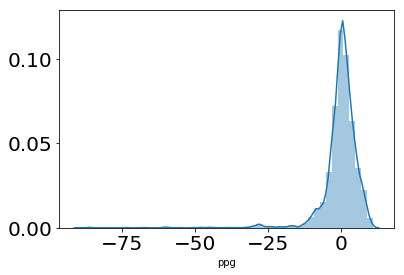

In [56]:
residual = ppg_Pred_C0-y0
sns.distplot(residual)

In [57]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residual, X0)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 102.31820461737087, 'LM-Test p-value': 5.340804010345873e-18, 'F-Statistic': 11.611866817473787, 'F-Test p-value': 3.252353589160689e-18}


In [58]:
formatResult(bp_test)

,Name,Test Result
0,LM Statistic,102.3182
1,LM-Test p-value,0.0000
2,F-Statistic,11.6119
3,F-Test p-value,0.0000


## Regression in cluster1(Second Cluster)

In [59]:
y1 = dat_C1['ppg']
X1 = dat_C1.drop(['ppg','state_code','Cluster','state','month', 'year'] , axis =1 )
X1.head() 

,dayspostlegal,distance,legal,quality_score,quantity,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy
4463,96,3287.9729,0,3,3.543690,0,0,1,0,1
4464,195,3287.9729,0,1,28.349524,0,0,1,0,1
4465,276,3283.6340,0,3,14.174762,0,0,1,0,1
4466,295,3287.9729,0,2,28.349524,0,0,1,0,1
4467,104,3283.6340,0,3,7.087381,0,0,1,0,1


In [60]:
cluster1_model = LinearRegression()
cluster1_model.fit(X1,y1)
ppg_Pred_C1 = cluster1_model.predict(X1)

In [61]:
pd. Series( cluster1_model.coef_ , index = X1.columns).sort_values(ascending = False).round(2)

quality_score       0.87
state_Washington    0.41
year_dummy          0.27
distance            0.00
dayspostlegal       0.00
state_New Mexico    0.00
state_Colorado     -0.00
quantity           -0.14
state_Oregon       -0.41
legal              -0.59
dtype: float64

In [62]:
print(' The r-quared value for this model is  %.4f' % r2_score(y1 ,ppg_Pred_C1))
print(' The mean squared error value for this model is  %.4f' % mean_squared_error(y1 ,ppg_Pred_C1))

 The r-quared value for this model is  0.0952
 The mean squared error value for this model is  24.3861


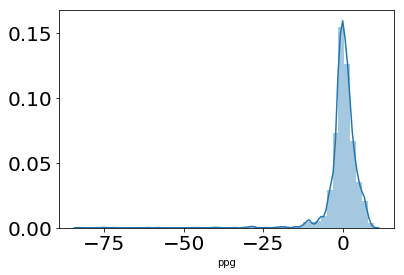

In [63]:
residual = ppg_Pred_C1-y1
sns.distplot(residual)

In [64]:
bp_test = het_breuschpagan(residual, X1)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 22.90480464133686, 'LM-Test p-value': 0.006413689056579669, 'F-Statistic': 3.2822372547978413, 'F-Test p-value': 0.0017509594218497325}


In [65]:
formatResult(bp_test)

,Name,Test Result
0,LM Statistic,22.9048
1,LM-Test p-value,0.0064
2,F-Statistic,3.2822
3,F-Test p-value,0.0018


## Regression Part

In [66]:
# getting back the the main dataset
marijuana.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year
0,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013
1,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013
2,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013
3,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013
4,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013


In [67]:
marijuana['year_dummy'] = (marijuana['year'] == 2013).astype('int')

In [68]:
# counting each column
marijuana_data.count()

state               9306
state_code          9306
dayspostlegal       9306
distance            9306
legal               9306
month               9306
ppg                 9306
quality_score       9306
quantity            9306
year                9306
state_Colorado      9306
state_New Mexico    9306
state_Oregon        9306
state_Washington    9306
year_dummy          9306
Cluster             9306
dtype: int64

##### Check outliers

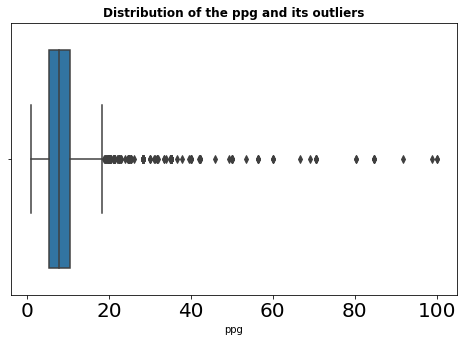

In [69]:
# Another way to draw a diagram
plt.rcParams["figure.figsize"]=8,5
plt.title("Distribution of the ppg and its outliers", weight="bold")
sns.boxplot(x=marijuana.ppg)
plt.savefig("ppg.png")
plt.show()

##### We have lots of outliers. I am going to remove them

In [70]:
# Now we know we have outliers so we try to remove them
# We prepare first quarter and third quarter 
q1=marijuana.ppg.quantile(0.25)
q3=marijuana.ppg.quantile(0.75)
IQR=q3-q1
lower=q1-1.5*IQR
upper=q3+1.5*IQR

In [71]:
# Then we remove the outliers and create a new dataframe
data = marijuana.loc[(marijuana.ppg > lower) & (marijuana.ppg < upper)]

##### After removing outliers

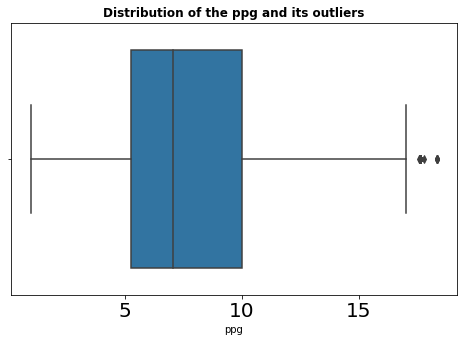

In [72]:
# Another way to draw a diagram
plt.rcParams["figure.figsize"]=8,5
plt.title("Distribution of the ppg and its outliers", weight="bold")
sns.boxplot(x=data.ppg)
plt.savefig("ppg.png")
plt.show()

In [73]:
data = pd.concat([data, pd.get_dummies(data['state'], prefix='state')], axis=1)
data.drop(['state_Nevada'] , axis =1 , inplace = True)
data.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year,year_dummy,state_Colorado,state_New Mexico,state_Oregon,state_Washington
0,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013,1,1,0,0,0
1,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013,1,1,0,0,0
2,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013,1,1,0,0,0
3,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013,1,1,0,0,0
4,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013,1,1,0,0,0


##### We took logarithm to remove heteroskedasticity. Although at the end this technique did not help us.

##### We start to prepare our model and seperate x and y

In [74]:
# target value 
yy = data['ppg']
y = yy
#y = np.log(yy) (Prof. had said not to use log for dependent variable)
y.head()

0    8.113011
1    7.054792
2    7.054792
3    8.465751
4    8.818490
Name: ppg, dtype: float64

In [75]:
# predictor variables
x = data.drop(["state","state_code",'ppg','month','year', "income"] , axis =1)
# get the names of the comlumn
x.columns


Index(['dayspostlegal', 'distance', 'legal', 'quality_score', 'quantity',
       'year_dummy', 'state_Colorado', 'state_New Mexico', 'state_Oregon',
       'state_Washington'],
      dtype='object')

In [76]:
# importing train and test from sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=123)

## Decision Tree Regression


In [77]:
# importing required library
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

##### I want to determine the optimal value for max_depth of the decision tree. I useed mean squarred error. The one that has minimum mse is the best on. 

In [78]:
#creating a range for max depth
max_depth_range = np.arange(1, 15)
# Create a list for mean score error
new_mse = []
# creating a loop to go through all numbers of max depth
for depth in max_depth_range:
    regressionTree_depth = DecisionTreeRegressor(max_depth = depth, 
                             random_state =200)
    regressionTree_depth.fit(x_train, y_train)
    y_predict_regressionTree_test = regressionTree_depth.predict(x_test)
    score = mean_squared_error(y_test,y_predict_regressionTree_test)
    new_mse.append(score)

##### max_depth=5 is the best one

In [79]:
# for the depth of the tree we can find the best "max_depth" by checking the lowest value for new_mse
new_mse

[11.34851576532925,
 10.69126623847129,
 9.979693364951087,
 9.79609561607115,
 9.79352476889683,
 9.894572185807567,
 10.049809906681386,
 10.4551276310776,
 10.752528652657812,
 11.275032877768295,
 11.80306604528016,
 12.082509766922556,
 12.783591283083892,
 13.81929051400825]

##### I create a diagram for it

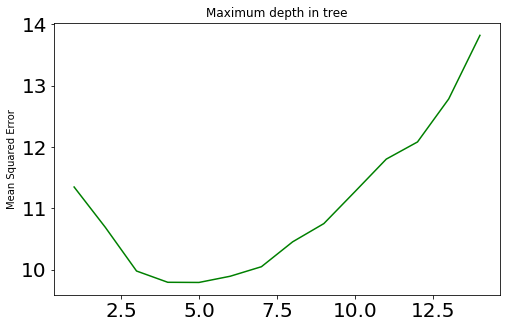

In [80]:
# draw the picture above for better understanding
plt.plot(np.arange(1, 15), new_mse, color="g")
plt.title("Maximum depth in tree")
plt.ylabel("Mean Squared Error")
plt.savefig("Max_depth")
plt.show()

In [81]:
# Regresion decision tree
regressionTree= DecisionTreeRegressor(max_depth=5 ,random_state=200)

In [82]:
regressionTree_train=regressionTree.fit(x_train, y_train)
y_predict_regressionTree_train = regressionTree.predict(x_train)
mse_tree_train = mean_squared_error(y_true=y_train, y_pred=y_predict_regressionTree_train)
mse_tree_train.round(2)

9.23

In [83]:
y_predict_regressionTree_test = regressionTree.predict(x_test)
mse_tree_test = mean_squared_error(y_test,y_predict_regressionTree_test)
mse_tree_test.round(2)

9.79

In [84]:
pd.DataFrame({"Actual": y_train, "Predict-train": y_predict_regressionTree_train}).head()

,Actual,Predict-train
3898,8.993362,10.342364
9174,7.054792,6.202467
3857,8.818490,6.202467
7794,5.996573,7.112677
8162,10.021011,8.023380


In [85]:
print("MSE-train {:.3}".format(mse_tree_train))
print("MSE-test {:.3}".format(mse_tree_test))

MSE-train 9.23
MSE-test 9.79


In [86]:
# importing libraries to draw decision tree
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

In [87]:
#os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

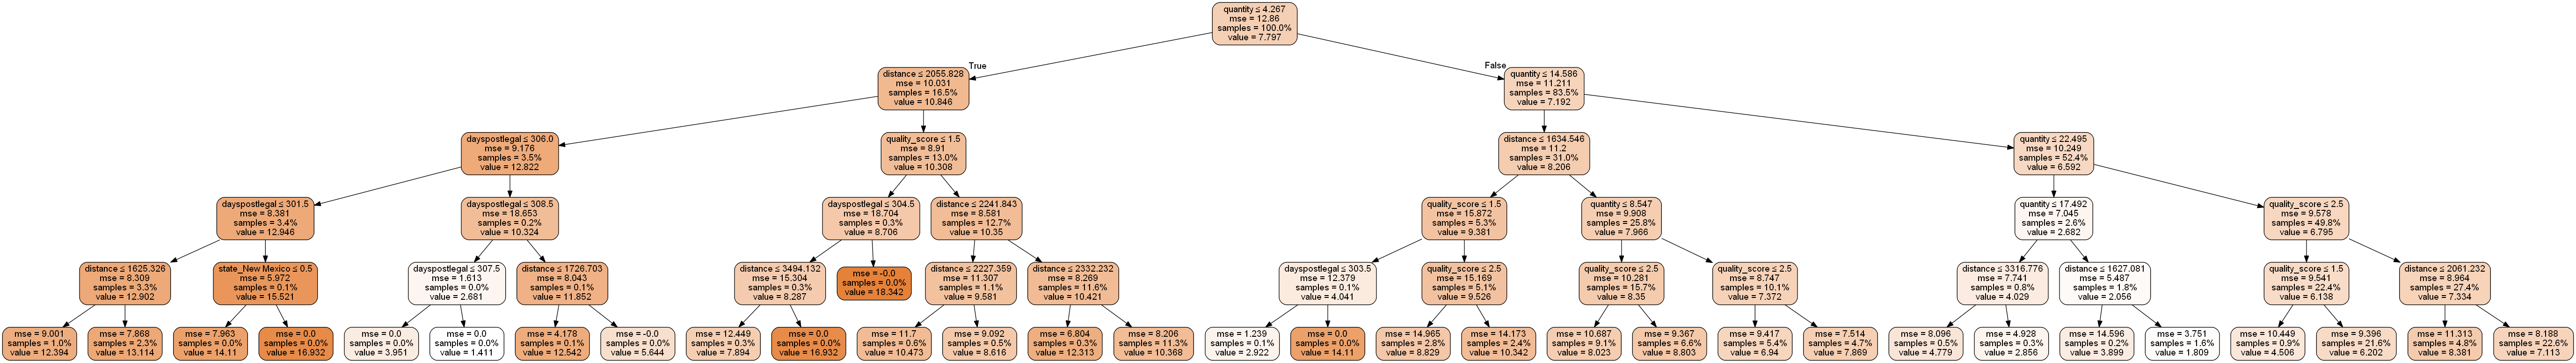

In [88]:
dot_data = StringIO()
export_graphviz(decision_tree=regressionTree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                proportion=True,
                feature_names = x_train.columns,
                class_names =True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Marijunan.jpeg')
Image(graph.create_png())

##### I wanted to know the most important of x varaibles. 

In [89]:
# create data frame to list the importance of the independent variables
pd.DataFrame({"Variable":x_train.columns, "Importance":regressionTree.feature_importances_}).sort_values(by=['Importance'], ascending=False)

,Variable,Importance
4,quantity,0.785295
1,distance,0.107622
3,quality_score,0.089148
0,dayspostlegal,0.017630
7,state_New Mexico,0.000306
2,legal,0.000000
5,year_dummy,0.000000
6,state_Colorado,0.000000
8,state_Oregon,0.000000
9,state_Washington,0.000000


## Linear Regression

In [90]:
#Create an instance for regression model
ml_rg=LinearRegression()
#Fit the model
ml_rg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [91]:
y_predict_ml_rg_train=ml_rg.predict(x_train).round(3)
y_predict_ml_rg_train[:5]

array([10.129,  5.952,  6.771,  6.937,  8.86 ])

In [92]:
y_predict_ml_rg_test=ml_rg.predict(x_test).round(3)
y_predict_ml_rg_test[:5]

array([6.288, 8.697, 8.282, 5.261, 8.141])

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
model_mse_train=mean_squared_error(y_train, y_predict_ml_rg_train)
model_mse_test=mean_squared_error(y_test, y_predict_ml_rg_test)
model_mae=mean_absolute_error(y_test, y_predict_ml_rg_test)
model_rmse=math.sqrt(model_mse_train)

print("MSE-train {:.3}".format(model_mse_train))
print("MSE-test {:.3}".format(model_mse_test))
print("MSAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE-train 10.5
MSE-test 10.8
MSAE 2.51
RMSE 3.24


##### I used Robust regression model to again try to control heteroskedasticity. But does not help.

In [94]:
import statsmodels.api as sm
x2=sm.add_constant(x)
rlm_model = sm.RLM(y, x2, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
rlm_results.summary()

C:\Users\srija\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    ppg   No. Observations:                 8959
Model:                            RLM   Df Residuals:                     8948
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 01 Dec 2019                                         
Time:                        14:09:58                                         
No. Iterations:                    21                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.0399      0.415     24.185      0.000       9.226      10.854
dayspostlegal       -0.0003      0.000     -0.815      0.415      -0.001       0.000
distance            -0.0010      0.000     -4.986      0.000      -0.001      -0.001
legal               -0.2388      0.121     -1.973      0.048      -0.476      -0.002
quality_score        1.1744      0.063     18.708      0.000       1.051       1.297
quantity            -0.1307      0.003    -41.993      0.000      -0.137      -0.125
year_dummy           0.0421      0.128      0.329      0.742      -0.209       0.293
state_Colorado      -0.5510      0.174     -3.175      0.001      -0.891      -0.211
state_New Mexico     0.0869      0.161      0.540      0.589      -0.228       0.402
state_Oregon        -0.3313      0.309     -1.072      0.284      -0.937       0.275
state_Washington     0.7441      0.355      2.095      0.036       0.048       1.440
====================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [95]:
y_pred=rlm_results.predict(x2)

In [96]:
y_pred=rlm_results.predict(x2)

In [97]:
residual1=rlm_results.resid
residual1.head(10)

0    1.480791
1    1.174678
2    0.403506
3    1.183854
4    3.227699
5    3.922323
6   -1.803147
7   -5.724937
8   -3.137185
9    0.174620
dtype: float64

##### I used jarque_bera test for to check the normality of Robust regression modle. It is not normal

In [98]:
from scipy import stats
stats.jarque_bera(residual1)

(163.2979733851263, 0.0)

In [99]:
# =============================================================================
# Heteroskedasticity test for Robust one
# =============================================================================
## Breusch-Pagan
import statsmodels
breuschpagan=statsmodels.stats.diagnostic.het_breuschpagan(residual1, x)
formatResult(breuschpagan)

,Name,Test Result
0,LM Statistic,2536.4025
1,LM-Test p-value,0.0000
2,F-Statistic,353.4126
3,F-Test p-value,0.0000


#####  LM-Test p-value and F-Test p-value help us to determine whether we have heteroskedasticity or not. When they are zero it means we have heteroskedasticity and this is not a good result

##### I get back to regular regression model with stats library. Here I am trying to apply better model if it can help

In [100]:
x2=sm.add_constant(x)
model=sm.OLS(y, x2)
est=model.fit()

In [101]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     199.7
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        14:09:58   Log-Likelihood:                -23276.
No. Observations:                8959   AIC:                         4.657e+04
Df Residuals:                    8948   BIC:                         4.665e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.4711      0.423  

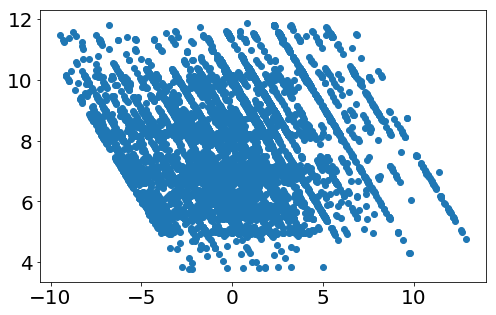

In [102]:
plt.scatter(residual1,y_pred)

In [103]:
# Calculating residuals for regular regression model
residual=est.resid
residual.head(10)

0    1.224063
1    0.989376
2    0.159199
3    1.054775
4    2.996411
5    3.683605
6   -1.770735
7   -5.738443
8   -3.358329
9   -0.078714
dtype: float64

In [104]:
### Test normality of residual
# D'Agostino and Pearson's Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
seed(1)

stat, p = normaltest(residual)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=100.449, p=0.000
Sample does not look Gaussian (reject H0)


0.991649500923589

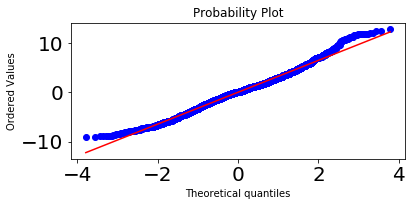

In [105]:
# drwing Q-Q plot for normality test for linear regreesion model- our residuals are not notmal
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

In [106]:
# jarque_bera for ols model
from scipy import stats
stats.jarque_bera(residual)

(136.219432057773, 0.0)

## KNN Regression

In [107]:
np.sqrt(marijuana_data.quantity.count()).round(2)

96.47

In [108]:
from sklearn.neighbors import KNeighborsRegressor
# 2. Create an instance of the class
knn = KNeighborsRegressor(n_neighbors=161)
# 3. Use the fit method of the instance
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=161, p=2,
          weights='uniform')

In [109]:
# 4. Use the predict method to get the predictions
y_predict_knn_train = knn.predict(x_train)
mse_knn_train = mean_squared_error(y_true=y_train, y_pred=y_predict_knn_train)
mse_knn_train.round(2)

12.1

In [110]:
y_predict_knn_test = knn.predict(x_test)
mse_knn_test = mean_squared_error(y_true=y_test, y_pred=y_predict_knn_test)
mse_knn_test.round(2)

12.47

In [111]:
mse = pd.DataFrame(columns=['train', 'test'], index=['Linear Regression','Regression Tree','KNN'])
mse.loc['Linear Regression', 'train'] = model_mse_train.round(2)
mse.loc['Linear Regression', 'test'] = model_mse_test.round(2)
    
mse.loc['Regression Tree', 'train'] = mse_tree_train.round(2)
mse.loc['Regression Tree', 'test'] = mse_tree_test.round(2)
    
mse.loc['KNN', 'train'] =  mse_knn_train.round(2)
mse.loc['KNN', 'test'] = mse_knn_test.round(2)
mse

,train,test
Linear Regression,10.52,10.8
Regression Tree,9.23,9.79
KNN,12.1,12.47


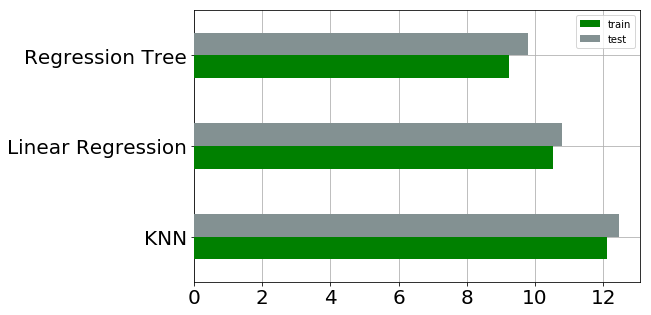

In [112]:
fig, ax = plt.subplots()
color_list=["g","#839192"]
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3, color=color_list)
ax.grid(zorder=0)

In [113]:
pd.DataFrame({"Actual": y_test, "Linear Regression-test": y_predict_ml_rg_test,
              "Decision Tree-test":y_predict_regressionTree_test , "KNN-test":y_predict_knn_test}).head()

,Actual,Linear Regression-test,Decision Tree-test,KNN-test
5114,10.582189,6.288,7.112677,7.529474
8559,10.021011,8.697,8.023380,7.692917
3303,9.523970,8.282,8.381199,9.279299
5537,5.291094,5.261,6.202467,7.090867
3477,2.001359,8.141,3.899316,8.940401


## Clustering without outliers

In [114]:
data.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year,year_dummy,state_Colorado,state_New Mexico,state_Oregon,state_Washington
0,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013,1,1,0,0,0
1,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013,1,1,0,0,0
2,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013,1,1,0,0,0
3,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013,1,1,0,0,0
4,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013,1,1,0,0,0


In [115]:
numerical_features = ['quantity','distance' ,'dayspostlegal','quality_score']

In [116]:
sub_data = data
sub_set = data[numerical_features]
sub_set.head()

,quantity,distance,dayspostlegal,quality_score
0,28.349524,2343.9370,253,3
1,28.349524,1947.1980,201,2
2,28.349524,2343.9370,193,3
3,14.174762,2358.2251,297,2
4,28.349524,2230.3601,200,2


## Clustering  with two cluster

In [117]:
kmeans = KMeans(n_clusters = 2, random_state = 123).fit(sub_set)
centroids = (kmeans.cluster_centers_)
labels2  = (kmeans.labels_)
pd.DataFrame(centroids ,columns = sub_set.columns)

,quantity,distance,dayspostlegal,quality_score
0,17.416103,2053.286848,72.183606,2.491590
1,18.429555,3327.390684,63.165049,2.455889


In [118]:
# Calculate silhouette_score
print(silhouette_score(sub_set, kmeans.labels_))

0.700816999048858


## Clustering with three Clusters

In [119]:
kmeans = KMeans(n_clusters = 3, random_state = 123).fit(sub_set)
centroids = (kmeans.cluster_centers_)
labels = (kmeans.labels_)
pd.DataFrame(centroids ,columns = sub_set.columns)

,quantity,distance,dayspostlegal,quality_score
0,16.994785,1630.496353,71.204044,2.480392
1,18.420812,3329.213674,63.246613,2.456605
2,17.701574,2321.907568,72.601229,2.497119


In [120]:
# Calculate silhouette_score
print(silhouette_score(sub_set, kmeans.labels_))

0.6918076363092881


## The silhouette_score is greater when the number of cluster is 2. So running regression in 2 clusters

In [121]:
sub_data.shape

(8959, 16)

In [122]:
## Creating a cluster column in sub_data dataframe
sub_data['Cluster'] = labels2

In [123]:
sub_data.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year,year_dummy,state_Colorado,state_New Mexico,state_Oregon,state_Washington,Cluster
0,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013,1,1,0,0,0,0
1,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013,1,1,0,0,0,0
2,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013,1,1,0,0,0,0
3,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013,1,1,0,0,0,0
4,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013,1,1,0,0,0,0


## Regression of Cluster 0 (first Cluster)

In [124]:
y0 = dat_C0['ppg']
X0 = dat_C0.drop(['ppg','state_code','Cluster','state','month', 'year'] , axis =1)
X0.head()    

,dayspostlegal,distance,legal,quality_score,quantity,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy
0,253,2343.9370,1,3,28.349524,1,0,0,0,1
1,201,1947.1980,1,2,28.349524,1,0,0,0,1
2,193,2343.9370,1,3,28.349524,1,0,0,0,1
3,297,2358.2251,1,2,14.174762,1,0,0,0,1
4,200,2230.3601,1,2,28.349524,1,0,0,0,1


In [125]:
cluster0_model = LinearRegression()
cluster0_model.fit(X0,y0 )
ppg_Pred_C0 = cluster0_model.predict(X0)

In [126]:
pd. Series( cluster0_model.coef_ , index = X0.columns).sort_values(ascending = False).round(2)

quality_score       1.14
legal               0.40
state_Colorado      0.15
state_Oregon       -0.00
dayspostlegal      -0.00
distance           -0.00
year_dummy         -0.16
quantity           -0.17
state_New Mexico   -0.25
state_Washington   -0.82
dtype: float64

In [127]:
print(' The r-quared value for this model is  %.4f' % r2_score(y0 ,ppg_Pred_C0))
print(' The mean squared error value for this model is  %.4f' % mean_squared_error(y0 ,ppg_Pred_C0))

 The r-quared value for this model is  0.0988
 The mean squared error value for this model is  40.7466


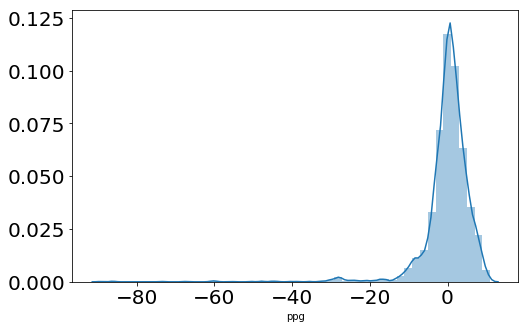

In [128]:
residual = ppg_Pred_C0-y0
sns.distplot(residual)

In [129]:
formatResult(bp_test)

,Name,Test Result
0,LM Statistic,22.9048
1,LM-Test p-value,0.0064
2,F-Statistic,3.2822
3,F-Test p-value,0.0018


## Regression in cluster1(Second Cluster)

In [130]:
y1 = dat_C1['ppg']
X1 = dat_C1.drop(['ppg','state_code','Cluster','state','month', 'year'] , axis =1 )
X1.head() 

,dayspostlegal,distance,legal,quality_score,quantity,state_Colorado,state_New Mexico,state_Oregon,state_Washington,year_dummy
4463,96,3287.9729,0,3,3.543690,0,0,1,0,1
4464,195,3287.9729,0,1,28.349524,0,0,1,0,1
4465,276,3283.6340,0,3,14.174762,0,0,1,0,1
4466,295,3287.9729,0,2,28.349524,0,0,1,0,1
4467,104,3283.6340,0,3,7.087381,0,0,1,0,1


In [131]:
cluster1_model = LinearRegression()
cluster1_model.fit(X1,y1)
ppg_Pred_C1 = cluster1_model.predict(X1)

In [132]:
pd. Series( cluster1_model.coef_ , index = X1.columns).sort_values(ascending = False).round(2)

quality_score       0.87
state_Washington    0.41
year_dummy          0.27
distance            0.00
dayspostlegal       0.00
state_New Mexico    0.00
state_Colorado     -0.00
quantity           -0.14
state_Oregon       -0.41
legal              -0.59
dtype: float64

In [133]:
print(' The r-quared value for this model is  %.4f' % r2_score(y1 ,ppg_Pred_C1))
print(' The mean squared error value for this model is  %.4f' % mean_squared_error(y1 ,ppg_Pred_C1))

 The r-quared value for this model is  0.0952
 The mean squared error value for this model is  24.3861


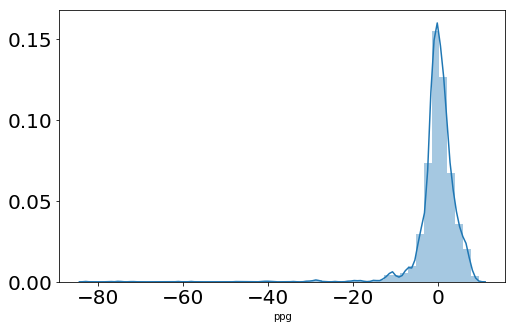

In [134]:
residual = ppg_Pred_C1-y1
sns.distplot(residual)

In [135]:
formatResult(bp_test)

,Name,Test Result
0,LM Statistic,22.9048
1,LM-Test p-value,0.0064
2,F-Statistic,3.2822
3,F-Test p-value,0.0018
